## Analyzing and forecasting forest coverage impacts on air quality and the transmission of Covid-19 in India using machine learning
(Completed November 2020)

The Covid-19 virus spreads respiratorily as people come in contact with one another. Preliminary evidence in the United States (as of November 2020) shows that environmental factors such as forest density and air quality may have an impact on the spread and mortality rate of Covid-19 ([Costello, 2020](https://scopeblog.stanford.edu/2020/07/17/why-air-pollution-is-linked-to-severe-cases-of-covid-19/)).
- Repiratory and cardiovascular complications are impacted by air quality ([Forouzanfar et al., 2017](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(17)32366-8/fulltext#articleInformation)).
- Air quality depends on the capacity of trees to remove air pollutants and eliminate volatile organic compounds that contribute to ozone and PM2.5 formation ([Chameides et al.,1988](https://www.science.org/doi/10.1126/science.3420404)). 
- India has high air pollution from urbanization and industry, particularly from the energy sector which might worsen the transmission of Covid-19 ([Contreras and Ferri, 2016](https://www.sciencedirect.com/science/article/pii/S187705091630758X)). 

This analysis investigates the relationship between forest coverage and air quality with the number of Covid-19 cases in India. It aims to answer the following question: <em>Does high forest coverage slow the spread of Covid-19 and minimize cases in India due to better air quality?</em>

The data used in this analysis is from open source resources:
- AnuragAnalog. (2020, June 19). Geodata-of-India [Dataset](https://github.com/AnuragAnalog/Geodata-of-India)
- Development Data Lab. (2020, April 14). Development Data Lab [Dataset](http://www.devdatalab.org/covid)
- Socioeconomic High-resolution Rural-Urban Geographic Platform



#### Approach
1. Conduct exploratory data analysis by each Indian state, examining the following three main variable groups: air quality, health and demographic, and Covid-19 cases. 
    - Air quality variables are total area of forest, the forest cover value, and mean pollution. 
    - Health and demographic variables are slum, work and total population, urban share, population density and number of doctors and hospitals. 
    - Covid-19 variables are total cases and deaths. 

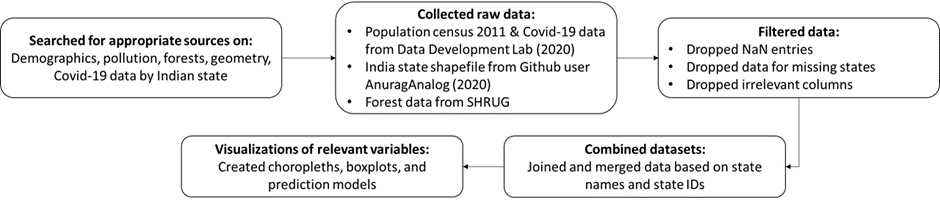

2. Apply spatial visualization, regression, and clustering algorithms to identify patterns and relationships between variables. 


### Data collection and interrogation

Covid-19 data
- Data from January 30 to April 26, 2020 from the Data Development Lab India (DLL India). Files used: covid_cases_deaths_district.csv, covid_deaths_recoveries.csv, and covid_infected_deaths.csv 
- The following operations were done: 
    - Renamed the state names according to the state name in shapefile
    - Merged Covid_cases_death_districts with death_recoveries by state_id
    - Dropped duplicates
    - Recovered number of Covid-19 patients by summing up grouped data by state

Health and demographics data
- The files titled pc11_demographics.csv and health_district_pc11.csv are from DLL India and the Socioeconomic High-resolution Rural-Urban Geographic Platform (SHRUG) (2020). The demographics data is from the 2011 population census; the relevant variables are StateID, UrbanShare, PopDens, StateName, SlumPop, TotPop, WorkPopGeo. 

Air quality and forest data
- The mean pollution data (ddl_pollution_sedac_lgd.csv) is from DLL India and includes data on mean pollution per state. The state names were renamed according to the state name in shapefile, merging on state ID.
- Forest data (Indian_forest.csv and shrug_ec13_state_key.csv) is from the SHRUG platform. This consists of a calculation of forest coverage by pixel density of each state photographed by satellites between 2000 and 2014. 2014 forest data was used because it is the most recent data available; the relevant variables are the total amount of forest coverage and the maximum value of forest cover (percent) in each district. This data was reformatted and cleaned by merging and averaging the data by state. States were renamed according to the state names in the shapefile and merged with the shapefile.

Final dataframe
- The aforementioned cleaned data along with the Indian shapefile, were saved as the final dataframe. The shape file was retrieved from Github user AnuragAnalog (2020) and contains the boundaries of India. 
- The variables of interest are: Total number of hospitals, Total number of doctors, urban share, population density, slum population, total population, working population, mean pollution, forest data from 2000 until 2014, ec13_state_id, Covid-19 deaths and cases and average.


In [35]:
# Import the Necessary Libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt 
import pandas as pd
import time
import statsmodels.api as sm
import requests
import IPython
from IPython.core.display import HTML
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

import geopandas as gpd
import palettable as pltt
from seaborn import palplot
import json
import contextily as ctx
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
np.random.seed(123)
from sklearn import cluster
from numpy.polynomial.polynomial import polyfit

## Exploratory Data Analysis

,geometry
StateName,
Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0..."
Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612..."
Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578..."
Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640..."
Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552..."


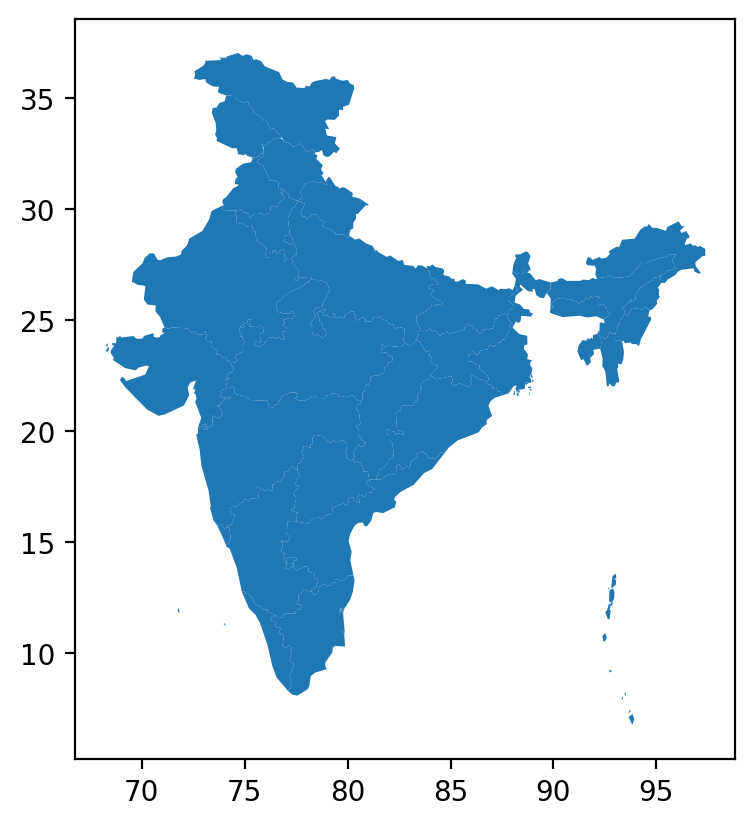

In [2]:
# Read in Shapefile of India
india_shapefile = gpd.read_file('data/India.shp')
india_shapefile.plot()
india_shapefile = india_shapefile.rename(columns={'st_nm':"StateName"})
india_shapefile = india_shapefile[['StateName', 'geometry']].set_index('StateName')
india_shapefile.head()

In [3]:
# Read in Demographics Data
demographics = pd.read_csv('data/pc11_demographics.csv')
demographics.head(2)

,pc11_state_id,pc11_district_id,pc11_subdistrict_id,pc11_urb_share,pc11_slum_pop,pc11_vd_area,pc11_td_area,pc11_tot_area,pc11_pop_dens,pc11_state_name,pc11_district_name,pc11_subdistrict_name,pc11r_pca_subdistrict_name,pc11r_pca_level,pc11r_pca_tru,pc11r_pca_no_hh,pc11r_pca_tot_p,pc11r_pca_tot_m,pc11r_pca_tot_f,pc11r_pca_p_06,pc11r_pca_m_06,pc11r_pca_f_06,pc11r_pca_p_sc,pc11r_pca_m_sc,pc11r_pca_f_sc,pc11r_pca_p_st,pc11r_pca_m_st,pc11r_pca_f_st,pc11r_pca_p_lit,pc11r_pca_m_lit,pc11r_pca_f_lit,pc11r_pca_p_ill,pc11r_pca_m_ill,pc11r_pca_f_ill,pc11r_pca_tot_work_p,pc11r_pca_tot_work_m,pc11r_pca_tot_work_f,pc11r_pca_mainwork_p,pc11r_pca_mainwork_m,pc11r_pca_mainwork_f,pc11r_pca_main_cl_p,pc11r_pca_main_cl_m,pc11r_pca_main_cl_f,pc11r_pca_main_al_p,pc11r_pca_main_al_m,pc11r_pca_main_al_f,pc11r_pca_main_hh_p,pc11r_pca_main_hh_m,pc11r_pca_main_hh_f,pc11r_pca_main_ot_p,pc11r_pca_main_ot_m,pc11r_pca_main_ot_f,pc11r_pca_margwork_p,pc11r_pca_margwork_m,pc11r_pca_margwork_f,pc11r_pca_marg_cl_p,pc11r_pca_marg_cl_m,pc11r_pca_marg_cl_f,pc11r_pca_marg_al_p,pc11r_pca_marg_al_m,pc11r_pca_marg_al_f,pc11r_pca_marg_hh_p,pc11r_pca_marg_hh_m,pc11r_pca_marg_hh_f,pc11r_pca_marg_ot_p,pc11r_pca_marg_ot_m,pc11r_pca_marg_ot_f,pc11r_pca_margwork36_p,pc11r_pca_margwork36_m,pc11r_pca_margwork36_f,pc11r_pca_marg_cl36_p,pc11r_pca_marg_cl36_m,pc11r_pca_marg_cl36_f,pc11r_pca_marg_al36_p,pc11r_pca_marg_al36_m,pc11r_pca_marg_al36_f,pc11r_pca_marg_hh36_p,pc11r_pca_marg_hh36_m,pc11r_pca_marg_hh36_f,pc11r_pca_marg_ot36_p,pc11r_pca_marg_ot36_m,pc11r_pca_marg_ot36_f,pc11r_pca_margwork03_p,pc11r_pca_margwork03_m,pc11r_pca_margwork03_f,pc11r_pca_marg_cl03_p,pc11r_pca_marg_cl03_m,pc11r_pca_marg_cl03_f,pc11r_pca_marg_al03_p,pc11r_pca_marg_al03_m,pc11r_pca_marg_al03_f,pc11r_pca_marg_hh03_p,pc11r_pca_marg_hh03_m,pc11r_pca_marg_hh03_f,pc11r_pca_marg_ot03_p,pc11r_pca_marg_ot03_m,pc11r_pca_marg_ot03_f,pc11r_pca_non_work_p,pc11r_pca_non_work_m,pc11r_pca_non_work_f,...,pc11u_pca_marg_hh03_f,pc11u_pca_marg_ot03_p,pc11u_pca_marg_ot03_m,pc11u_pca_marg_ot03_f,pc11u_pca_non_work_p,pc11u_pca_non_work_m,pc11u_pca_non_work_f,pc11u_pca_sex_2011,pc11_pca_subdistrict_name,pc11_pca_level,pc11_pca_tru,pc11_pca_no_hh,pc11_pca_tot_p,pc11_pca_tot_m,pc11_pca_tot_f,pc11_pca_p_06,pc11_pca_m_06,pc11_pca_f_06,pc11_pca_p_sc,pc11_pca_m_sc,pc11_pca_f_sc,pc11_pca_p_st,pc11_pca_m_st,pc11_pca_f_st,pc11_pca_p_lit,pc11_pca_m_lit,pc11_pca_f_lit,pc11_pca_p_ill,pc11_pca_m_ill,pc11_pca_f_ill,pc11_pca_tot_work_p,pc11_pca_tot_work_m,pc11_pca_tot_work_f,pc11_pca_mainwork_p,pc11_pca_mainwork_m,pc11_pca_mainwork_f,pc11_pca_main_cl_p,pc11_pca_main_cl_m,pc11_pca_main_cl_f,pc11_pca_main_al_p,pc11_pca_main_al_m,pc11_pca_main_al_f,pc11_pca_main_hh_p,pc11_pca_main_hh_m,pc11_pca_main_hh_f,pc11_pca_main_ot_p,pc11_pca_main_ot_m,pc11_pca_main_ot_f,pc11_pca_margwork_p,pc11_pca_margwork_m,pc11_pca_margwork_f,pc11_pca_marg_cl_p,pc11_pca_marg_cl_m,pc11_pca_marg_cl_f,pc11_pca_marg_al_p,pc11_pca_marg_al_m,pc11_pca_marg_al_f,pc11_pca_marg_hh_p,pc11_pca_marg_hh_m,pc11_pca_marg_hh_f,pc11_pca_marg_ot_p,pc11_pca_marg_ot_m,pc11_pca_marg_ot_f,pc11_pca_margwork36_p,pc11_pca_margwork36_m,pc11_pca_margwork36_f,pc11_pca_marg_cl36_p,pc11_pca_marg_cl36_m,pc11_pca_marg_cl36_f,pc11_pca_marg_al36_p,pc11_pca_marg_al36_m,pc11_pca_marg_al36_f,pc11_pca_marg_hh36_p,pc11_pca_marg_hh36_m,pc11_pca_marg_hh36_f,pc11_pca_marg_ot36_p,pc11_pca_marg_ot36_m,pc11_pca_marg_ot36_f,pc11_pca_margwork03_p,pc11_pca_margwork03_m,pc11_pca_margwork03_f,pc11_pca_marg_cl03_p,pc11_pca_marg_cl03_m,pc11_pca_marg_cl03_f,pc11_pca_marg_al03_p,pc11_pca_marg_al03_m,pc11_pca_marg_al03_f,pc11_pca_marg_hh03_p,pc11_pca_marg_hh03_m,pc11_pca_marg_hh03_f,pc11_pca_marg_ot03_p,pc11_pca_marg_ot03_m,pc11_pca_marg_ot03_f,pc11_pca_non_work_p,pc11_pca_non_work_m,pc11_pca_non_work_f,pc11_pca_sex_2011,_m_vd,_m_td,_m_slum
0,1,0,0,NaN,0.0,0.000000,316.31,316.31000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
demographics.info()
print('\n')
print("Number of entries with NaN values: ", demographics['pc11_state_name'].isnull().sum())
stateid = demographics[['pc11_state_id', 'pc11_state_name']]
stateid = stateid.drop_duplicates()
stateid = stateid[demographics['pc11_state_name'].notna()]
stateid = stateid.rename(columns={'pc11_state_id':'StateID', 'pc11_state_name':'StateName'})
stateid['StateName'] = stateid.StateName.str.title()
stateid.iloc[24, stateid.columns.get_loc('StateName')] = "Daman and Diu"
stateid.iloc[25, stateid.columns.get_loc('StateName')] = "Dadra and Nagar Haveli"
stateid.iloc[34, stateid.columns.get_loc('StateName')] = "Andaman and Nicobar Islands"
stateid.iloc[6, stateid.columns.get_loc('StateName')] = "Delhi"
stateid.iloc[0, stateid.columns.get_loc('StateName')] = "Jammu and Kashmir"
stateid.sort_values(by=['StateName'])
india_shapefile = pd.merge(india_shapefile, stateid, on=['StateName'], how='inner')
india_shapefile.sort_values(by=['StateName'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6003 entries, 0 to 6002
Columns: 282 entries, pc11_state_id to _m_slum
dtypes: float64(264), int64(3), object(15)
memory usage: 12.9+ MB


Number of entries with NaN values:  15


,StateName,geometry,StateID
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",35
33,Andhra Pradesh,"POLYGON ((81.10545 17.82313, 81.39342 17.81473...",28
1,Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",12
2,Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578...",18
3,Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",10
4,Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552...",4
5,Chhattisgarh,"POLYGON ((83.94694 23.62196, 83.95594 23.62406...",22
6,Dadra and Nagar Haveli,"POLYGON ((73.20640 20.12165, 73.20865 20.10695...",26
7,Daman and Diu,"POLYGON ((72.80144 20.37378, 72.84418 20.47463...",25
22,Delhi,"POLYGON ((77.19755 28.86191, 77.33703 28.67912...",7


In [5]:
# Remove rows with state name as NaN (there is only a small amount in the total dataset)
demographics = demographics[demographics['pc11_state_name'].notna()]
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5988 entries, 1 to 6002
Columns: 282 entries, pc11_state_id to _m_slum
dtypes: float64(264), int64(3), object(15)
memory usage: 12.9+ MB


In [6]:
number_states = demographics.pc11_state_name.unique()
print("There are ", demographics.pc11_state_name.nunique()," states in this dataset.")
print(number_states)

There are  35  states in this dataset.
['jammu kashmir' 'himachal pradesh' 'punjab' 'chandigarh' 'uttarakhand'
 'haryana' 'nct of delhi' 'rajasthan' 'uttar pradesh' 'bihar' 'sikkim'
 'arunachal pradesh' 'nagaland' 'manipur' 'mizoram' 'tripura' 'meghalaya'
 'assam' 'west bengal' 'jharkhand' 'odisha' 'chhattisgarh'
 'madhya pradesh' 'gujarat' 'daman diu' 'dadra nagar haveli' 'maharashtra'
 'andhra pradesh' 'karnataka' 'goa' 'lakshadweep' 'kerala' 'tamil nadu'
 'puducherry' 'andaman nicobar islands']


***Potential Relevant Variables for further exploration:***
- State ID
- Urban share
- Population density
- State name
- Slum population
- Total population
- Total work population

In [7]:
# Create new dataframe with only relevant variables
demo_keydata = demographics[['pc11_state_id', 'pc11_urb_share', 'pc11_pop_dens', 'pc11_state_name', 'pc11_slum_pop', 'pc11_pca_tot_p', 'pc11_pca_tot_work_p']]
demo_keydata = demo_keydata.rename(columns={'pc11_state_id': 'StateID', 'pc11_urb_share': 'UrbanShare', 'pc11_pop_dens': 'PopDens','pc11_state_name':'StateName' , 'pc11_slum_pop':'SlumPop', 'pc11_pca_tot_p': "TotPop", 'pc11_pca_tot_work_p':"WorkPop"})
demo_keydata

,StateID,UrbanShare,PopDens,StateName,SlumPop,TotPop,WorkPop
1,1,0.139747,1791.46420,jammu kashmir,15518.0,540914.0,136649.0
2,1,0.050499,923.98419,jammu kashmir,4957.0,269311.0,72132.0
3,1,0.258411,860.37457,jammu kashmir,0.0,60129.0,20283.0
4,1,0.000000,1085.65280,jammu kashmir,0.0,67596.0,16433.0
5,1,0.083645,1218.70200,jammu kashmir,13662.0,163333.0,44586.0
...,...,...,...,...,...,...,...
5998,35,0.000000,301.51035,andaman nicobar islands,0.0,25788.0,9237.0
5999,35,0.074838,299.43900,andaman nicobar islands,0.0,36626.0,12958.0
6000,35,0.148642,264.15210,andaman nicobar islands,0.0,53565.0,20558.0
6001,35,0.801097,1197.28720,andaman nicobar islands,14172.0,165754.0,68992.0


In [8]:
states = stateid.set_index('StateID')
slumpop = demo_keydata[['StateID', 'SlumPop']]
slumpop = slumpop.groupby(by=['StateID']).sum()
totpop = demo_keydata[['StateID', 'TotPop']]
totpop = totpop.groupby(by=['StateID']).sum()
workpop = demo_keydata[['StateID', 'WorkPop']]
workpop = workpop.groupby(by=['StateID']).sum()
urbanshare = demo_keydata[['StateID', 'UrbanShare']]
urbanshare = urbanshare.groupby(by=['StateID']).mean()
popdens = demo_keydata[['StateID', 'PopDens']]
popdens = popdens.groupby(by=['StateID']).mean()
demo_keydata = states.merge(slumpop, left_index=True, right_index=True)
demo_keydata = demo_keydata.merge(totpop, left_index=True, right_index=True)
demo_keydata = demo_keydata.merge(workpop, left_index=True, right_index=True)
demo_keydata = demo_keydata.merge(urbanshare, left_index=True, right_index=True)
demo_keydata = demo_keydata.merge(popdens, left_index=True, right_index=True)
demo_keydata.head(2)

,StateName,SlumPop,TotPop,WorkPop,UrbanShare,PopDens
StateID,,,,,,
1,Jammu and Kashmir,662061.997894,12541302.0,4322713.0,0.143407,1460.963428
2,Himachal Pradesh,61312.000000,6864602.0,3559422.0,0.053349,307.458928


#### Total Population

In [9]:
# Identify 5 highest populated states
pop_rank = demo_keydata[['StateName', 'TotPop']]
pop_rank = pop_rank.groupby(by=['StateName']).sum()
pop_rank = pop_rank.sort_values(by=['TotPop'], ascending=False)
pop_rank.head()

,TotPop
StateName,
Uttar Pradesh,199812341.0
Maharashtra,112374333.0
Bihar,104099452.0
West Bengal,91276115.0
Andhra Pradesh,84580777.0


In [10]:
# Identify 5 lowest populated states
pop_rank.tail()

,TotPop
StateName,
Sikkim,610577.0
Andaman and Nicobar Islands,380581.0
Dadra and Nagar Haveli,343709.0
Daman and Diu,243247.0
Lakshadweep,64473.0


             TotPop
count  3.500000e+01
mean   3.459586e+07
std    4.445234e+07
min    6.447300e+04
25%    1.421136e+06
50%    1.678794e+07
75%    6.076749e+07
max    1.998123e+08


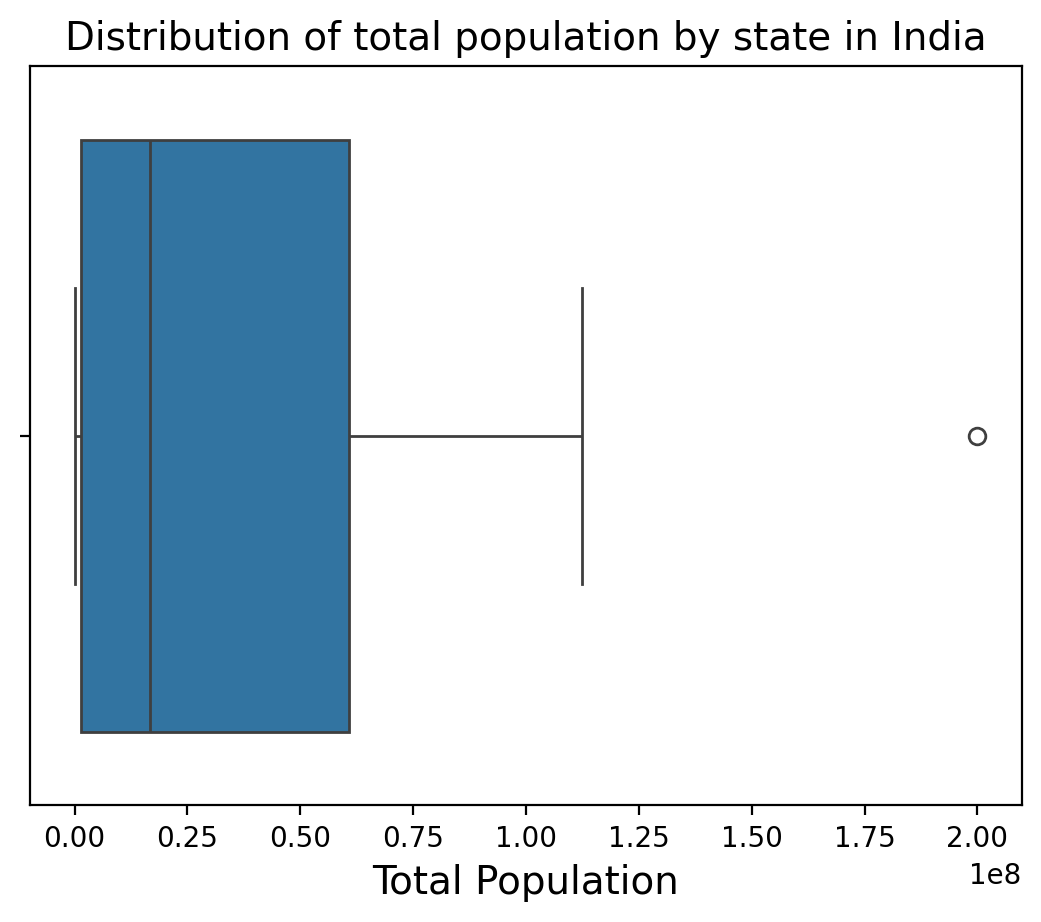

In [11]:
# Boxplot of population
ax = sns.boxplot(x='TotPop', data=pop_rank)
ax.set_ylabel(None);
ax.set_xlabel('Total Population', fontsize=14);
ax.set_title('Distribution of total population by state in India', fontsize=14);
print(pop_rank.describe())

#### Population Density

In [12]:
# Identify states with highest population density
density_rank = demo_keydata[['StateName', 'PopDens']]
density_rank = density_rank.groupby(by=['StateName']).sum()
density_rank = density_rank.sort_values(by=['PopDens'], ascending=False)
density_rank.head(10)

,PopDens
StateName,
Delhi,436254.520676
Arunachal Pradesh,83257.997758
Chandigarh,9258.333000
Meghalaya,7297.420073
Manipur,3888.494879
Puducherry,3481.217914
Daman and Diu,2310.891300
Lakshadweep,2274.846900
West Bengal,1573.464570


In [13]:
# Identify 5 lowest population density states
density_rank.tail()

,PopDens
StateName,
Uttarakhand,358.938353
Himachal Pradesh,307.458928
Rajasthan,305.556707
Madhya Pradesh,286.824335
Sikkim,129.036463


             PopDens
count      35.000000
mean    16207.235440
std     74409.591726
min       129.036463
25%       497.160842
50%       723.181684
75%      1548.420438
max    436254.520676


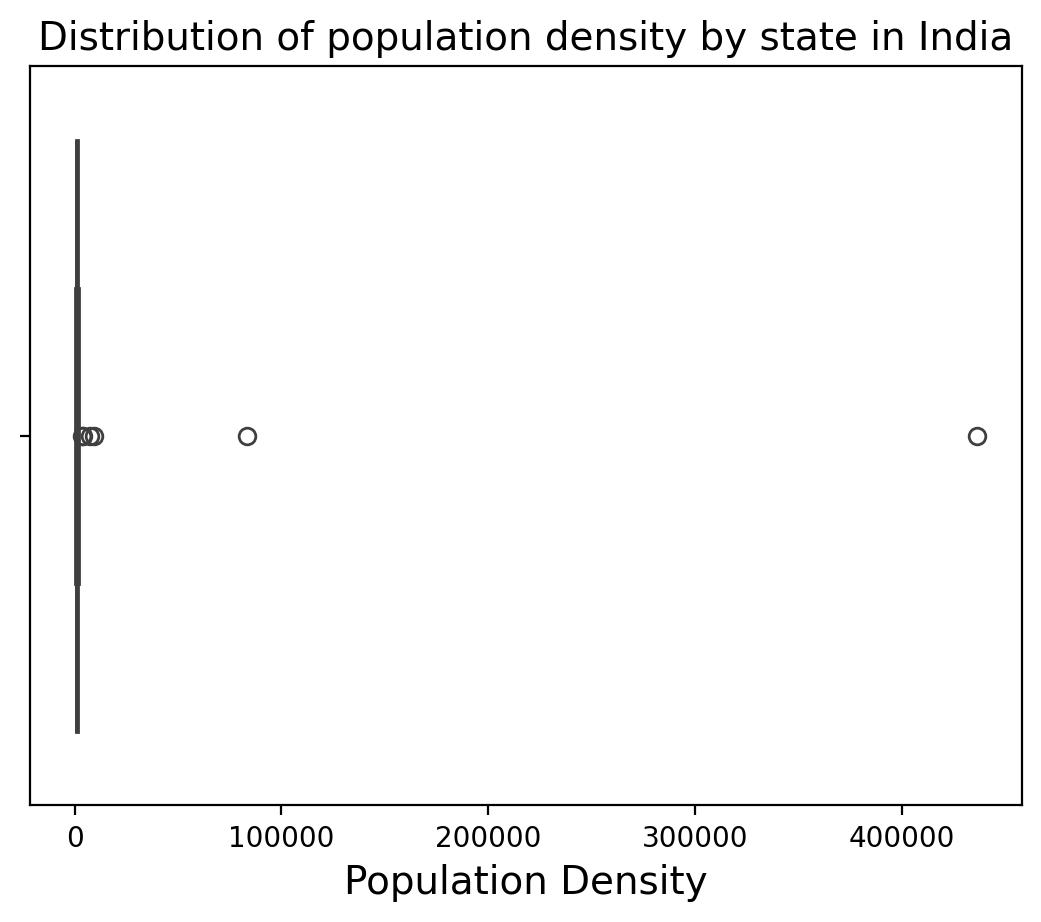

In [14]:
# Boxplot of population density
ax = sns.boxplot(x='PopDens', data=density_rank)
ax.set_ylabel(None);
ax.set_xlabel('Population Density', fontsize=14);
ax.set_title('Distribution of population density by state in India', fontsize=14);
print(density_rank.describe())

           PopDens
count    29.000000
mean    821.215727
std     557.725168
min     129.036463
25%     492.022210
50%     594.854243
75%    1077.264881
max    2310.891300


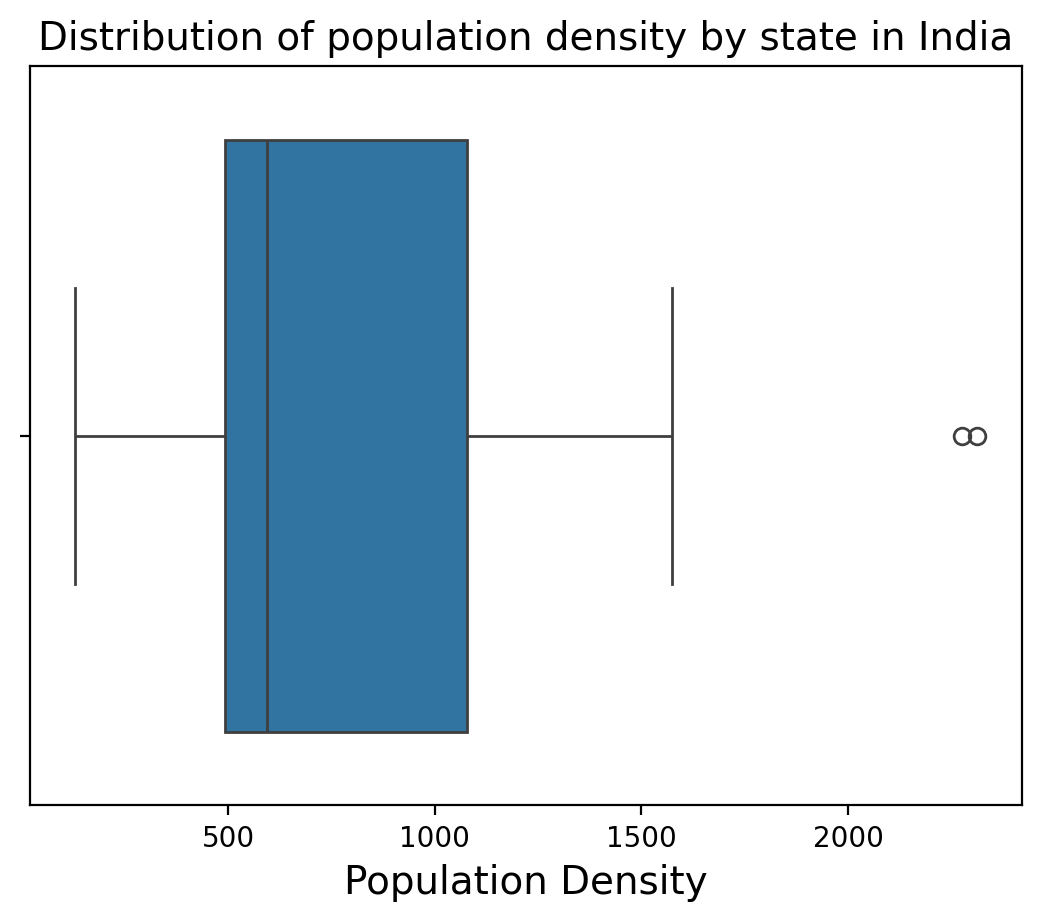

In [15]:
# Boxplot of population density removing outliers
density = density_rank.drop(['Delhi', 'Arunachal Pradesh', 'Chandigarh', 'Meghalaya', 'Manipur', 'Puducherry'])
ax = sns.boxplot(x='PopDens', data=density)
ax.set_ylabel(None);
ax.set_xlabel('Population Density', fontsize=14);
ax.set_title('Distribution of population density by state in India', fontsize=14);
print(density.describe())

#### Number of Cases and Deaths from Covid-19

In [16]:
# Read in cases csv file
cases_deaths = pd.read_csv('data/covid_cases_deaths_district.csv')
cases_deaths = cases_deaths[['pc11_state_id', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths']]
cases_deaths = cases_deaths.rename(columns={'pc11_state_id': 'StateID', 'new_cases': 'NewCases', 'new_deaths': 'NewDeaths','total_cases':'TotCases' ,'total_deaths' : 'TotDeaths'})
cases_deaths.head()

,StateID,NewCases,NewDeaths,TotCases,TotDeaths
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [17]:
# Aggregate all new and total cases and deaths
newcases = cases_deaths[['StateID', 'NewCases']]
newcases = newcases.groupby(by=['StateID']).sum()
newdeaths = cases_deaths[['StateID', 'NewDeaths']]
newdeaths = newdeaths.groupby(by=['StateID']).sum()
totcases = cases_deaths[['StateID', 'TotCases']]
totcases = totcases.groupby(by=['StateID']).sum()
totdeaths = cases_deaths[['StateID', 'TotDeaths']]
totdeaths = totdeaths.groupby(by=['StateID']).sum()
casesdeaths = newcases.merge(newdeaths, left_index=True, right_index=True)
casesdeaths = casesdeaths.merge(totcases, left_index=True, right_index=True)
casesdeaths = casesdeaths.merge(totdeaths, left_index=True, right_index=True)
casesdeaths.head(2)

,NewCases,NewDeaths,TotCases,TotDeaths
StateID,,,,
1,543,6,7794,106
2,40,2,795,53


In [18]:
# Merge with demo_keydata to have master dataframe
masterdata = demo_keydata.merge(casesdeaths, left_index=True, right_index=True)
masterdata.head(2)

,StateName,SlumPop,TotPop,WorkPop,UrbanShare,PopDens,NewCases,NewDeaths,TotCases,TotDeaths
StateID,,,,,,,,,,
1,Jammu and Kashmir,662061.997894,12541302.0,4322713.0,0.143407,1460.963428,543,6,7794,106
2,Himachal Pradesh,61312.000000,6864602.0,3559422.0,0.053349,307.458928,40,2,795,53


           PopDens
count    29.000000
mean    821.215727
std     557.725168
min     129.036463
25%     492.022210
50%     594.854243
75%    1077.264881
max    2310.891300


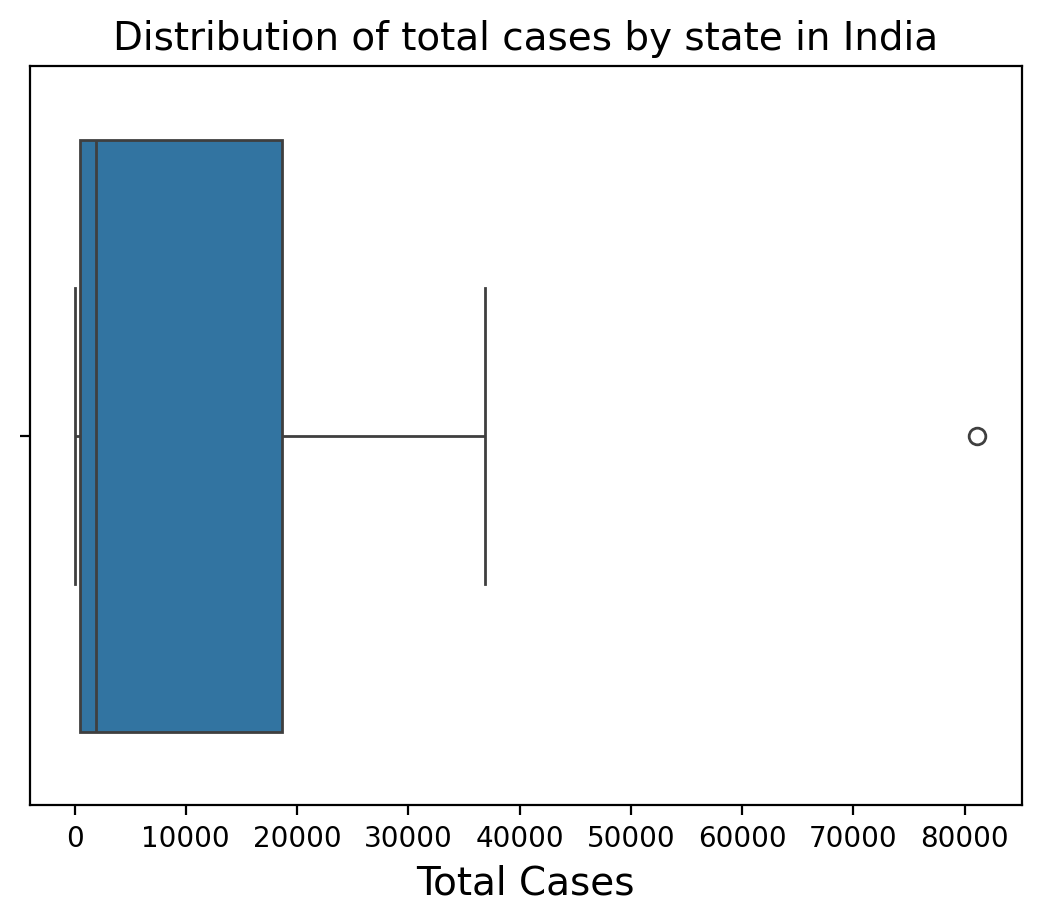

In [19]:
# Total Cases Boxplot
ax = sns.boxplot(x='TotCases', data=masterdata)
ax.set_ylabel(None);
ax.set_xlabel('Total Cases', fontsize=14);
ax.set_title('Distribution of total cases by state in India', fontsize=14);
print(density.describe())

In [20]:
cases = masterdata.sort_values(by=['TotCases'], ascending=False)
cases.head(10)

,StateName,SlumPop,TotPop,WorkPop,UrbanShare,PopDens,NewCases,NewDeaths,TotCases,TotDeaths
StateID,,,,,,,,,,
27,Maharashtra,1.184842e+07,112374333.0,49427878.0,0.200637,567.957049,8068,342,81074,4195
7,Delhi,1.785390e+06,16787941.0,5587049.0,0.985322,436254.520676,2918,54,36888,736
28,Andhra Pradesh,1.018693e+07,84580777.0,39422906.0,0.133628,496.788720,2098,56,30328,765
33,Tamil Nadu,5.798459e+06,72147030.0,32884681.0,0.355546,836.535296,1885,24,29235,312
24,Gujarat,1.680095e+06,60439692.0,24767747.0,0.215171,492.022210,3300,151,28596,1252
8,Rajasthan,2.068000e+06,68548437.0,29886255.0,0.160790,305.556707,2185,41,26698,353
23,Madhya Pradesh,5.688993e+06,72626809.0,31574133.0,0.174451,286.824335,2090,103,23621,1303
9,Uttar Pradesh,6.239965e+06,199812341.0,65814715.0,0.154793,893.587399,1873,30,20958,287
32,Kerala,2.020480e+05,33406061.0,11619063.0,0.383589,1193.093252,469,4,11715,75


           PopDens
count    29.000000
mean    821.215727
std     557.725168
min     129.036463
25%     492.022210
50%     594.854243
75%    1077.264881
max    2310.891300


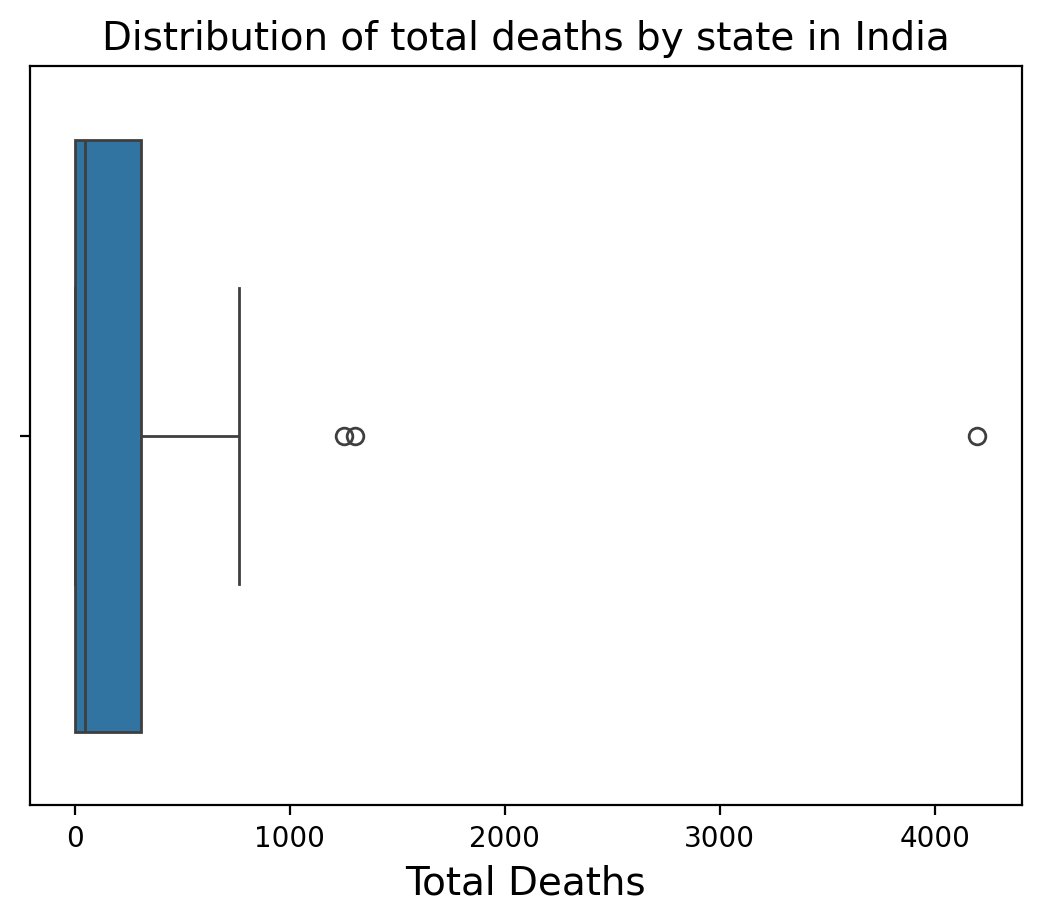

In [21]:
# Total Deaths Boxplot
ax = sns.boxplot(x='TotDeaths', data=masterdata)
ax.set_ylabel(None);
ax.set_xlabel('Total Deaths', fontsize=14);
ax.set_title('Distribution of total deaths by state in India', fontsize=14);
print(density.describe())

In [22]:
deaths = masterdata.sort_values(by=['TotDeaths'], ascending=False)
deaths.head(10)

,StateName,SlumPop,TotPop,WorkPop,UrbanShare,PopDens,NewCases,NewDeaths,TotCases,TotDeaths
StateID,,,,,,,,,,
27,Maharashtra,1.184842e+07,112374333.0,49427878.0,0.200637,567.957049,8068,342,81074,4195
23,Madhya Pradesh,5.688993e+06,72626809.0,31574133.0,0.174451,286.824335,2090,103,23621,1303
24,Gujarat,1.680095e+06,60439692.0,24767747.0,0.215171,492.022210,3300,151,28596,1252
28,Andhra Pradesh,1.018693e+07,84580777.0,39422906.0,0.133628,496.788720,2098,56,30328,765
7,Delhi,1.785390e+06,16787941.0,5587049.0,0.985322,436254.520676,2918,54,36888,736
8,Rajasthan,2.068000e+06,68548437.0,29886255.0,0.160790,305.556707,2185,41,26698,353
3,Punjab,1.460518e+06,27743338.0,9897362.0,0.279321,570.670202,322,18,4951,318
33,Tamil Nadu,5.798459e+06,72147030.0,32884681.0,0.355546,836.535296,1885,24,29235,312
29,Karnataka,3.291434e+06,61095297.0,27872597.0,0.234440,436.183207,503,19,8168,293


#### Hospitals and Doctors

In [23]:
health = pd.read_csv('data/health_district_pc11.csv')
health.head()

,pc11_state_id,pc11_district_id,pc11r_pca_tot_p,pc11u_pca_tot_p,pc11_pca_tot_p,pc11r_ag_main_share,pc11u_ag_main_share,pc11_ag_main_share,pc11r_pca_main_al_p,pc11r_pca_marg_al_p,pc11u_pca_main_al_p,pc11_pca_main_al_p,pc11r_pdensity,pc11u_pdensity,pc11_pdensity,pc11r_hl_dw_loc_inprem_no,pc11r_hl_dw_loc_nearprem_no,pc11r_hl_dw_loc_far_no,pc11u_hl_dw_loc_inprem_no,pc11u_hl_dw_loc_nearprem_no,pc11u_hl_dw_loc_far_no,pc11_tot_all_hosp,pc11_tot_all_hosp_doc_tot,pc11_tot_all_hosp_pmed_tot,pc11_tot_disp,pc11_tot_ch_cntr,pc11_tot_ph_cntr,pc11_tot_phs_cntr,pc11_tot_mcw_cntr,pc11_tot_tb_cln,pc11_tot_mh_cln,pc11_tot_fwc_cntr,pc11_tot_nh,pc11_tot_mh,pc11r_hl_dw_loc_inprem_sh,pc11r_hl_dw_loc_nearprem_sh,pc11r_hl_dw_loc_far_sh,pc11u_hl_dw_loc_inprem_sh,pc11u_hl_dw_loc_nearprem_sh,pc11u_hl_dw_loc_far_sh,pc11r_pca_tot_m,pc11r_pca_tot_f,pc11r_pca_p_06,pc11r_pca_m_06,pc11r_pca_f_06,pc11r_pca_p_sc,pc11r_pca_m_sc,pc11r_pca_f_sc,pc11r_pca_p_st,pc11r_pca_m_st,pc11r_pca_f_st,pc11r_pca_p_lit,pc11r_pca_m_lit,pc11r_pca_f_lit,pc11r_pca_p_ill,pc11r_pca_m_ill,pc11r_pca_f_ill,pc11r_pca_tot_work_p,pc11r_pca_tot_work_m,pc11r_pca_tot_work_f,pc11r_pca_mainwork_m,pc11r_pca_mainwork_f,pc11r_pca_main_cl_p,pc11r_pca_main_cl_m,pc11r_pca_main_cl_f,pc11r_pca_main_al_m,pc11r_pca_main_al_f,pc11r_pca_main_hh_p,pc11r_pca_main_hh_m,pc11r_pca_main_hh_f,pc11r_pca_main_ot_p,pc11r_pca_main_ot_m,pc11r_pca_main_ot_f,pc11r_pca_margwork_p,pc11r_pca_margwork_m,pc11r_pca_margwork_f,pc11r_pca_marg_cl_p,pc11r_pca_marg_cl_m,pc11r_pca_marg_cl_f,pc11r_pca_marg_al_m,pc11r_pca_marg_al_f,pc11r_pca_marg_hh_p,pc11r_pca_marg_hh_m,pc11r_pca_marg_hh_f,pc11r_pca_marg_ot_p,pc11r_pca_marg_ot_m,pc11r_pca_marg_ot_f,pc11r_pca_margwork36_p,pc11r_pca_margwork36_m,pc11r_pca_margwork36_f,pc11r_pca_marg_cl36_p,pc11r_pca_marg_cl36_m,pc11r_pca_marg_cl36_f,pc11r_pca_marg_al36_p,pc11r_pca_marg_al36_m,pc11r_pca_marg_al36_f,pc11r_pca_marg_hh36_p,pc11r_pca_marg_hh36_m,pc11r_pca_marg_hh36_f,pc11r_pca_marg_ot36_p,pc11r_pca_marg_ot36_m,pc11r_pca_marg_ot36_f,pc11r_pca_margwork03_p,pc11r_pca_margwork03_m,pc11r_pca_margwork03_f,pc11r_pca_marg_cl03_p,pc11r_pca_marg_cl03_m,pc11r_pca_marg_cl03_f,pc11r_pca_marg_al03_p,pc11r_pca_marg_al03_m,pc11r_pca_marg_al03_f,pc11r_pca_marg_hh03_p,pc11r_pca_marg_hh03_m,pc11r_pca_marg_hh03_f,pc11r_pca_marg_ot03_p,pc11r_pca_marg_ot03_m,pc11r_pca_marg_ot03_f,pc11r_pca_non_work_p,pc11r_pca_non_work_m,pc11r_pca_non_work_f,pc11r_pca_sex_2011,pc11u_pca_main_cl_p,pc11_slum_tot_p,pc11_pca_main_cl_p,pc11_urb_share,pc11r_pca_no_hh,pc11u_pca_no_hh,pc11_pca_no_hh,pc11_vd_area,pc11_td_area,pc11_area,pc11r_pca_mainwork_p,pc11u_pca_mainwork_p,pc11_pca_mainwork_p
0,1,1,733530,104729,838259,0.186024,0.010028,0.196051,8671,41683,699,9370,1248.91390,2212.2729,1320.77030,1.852249e+06,3.535700e+06,4.308323e+06,5.295594e+05,349211.799805,321234.097656,9,39.0,52,57,18,44,48,25,4,3,26,2,0,19.077059,36.415604,44.373161,44.133629,29.103409,26.771740,394554,338976,162986,86885,76101,743,741,2,66050,34551,31499,359084,228291,130793,374446,166263,208183,185908,153870,32038,84541,9503,13330,11161,2169,7773,898,2193,1565,628,69850,64042,5808,91864,69329,22535,18922,12729,6193,37229,4454,4142,2191,1951,27117,17180,9937,64511,49183,15328,13127,9437,3690,27550,24925,2625,3133,1648,1485,20701,13173,7528,27353,20146,7207,5795,3292,2503,14133,12304,1829,1009,543,466,6416,4007,2409,547622,240684,306938,298278,487,20475,13817,0.124936,97093,11999,109092,587.334304,47.34,634.67432,94044,24226,118270
1,1,2,566744,97912,664656,0.314775,0.021580,0.336355,9278,19428,925,10203,981.59875,2241.5752,1070.21630,3.643204e+06,2.812462e+06,1.258006e+06,1.047956e+06,273636.804077,73233.001755,17,152.0,429,66,8,43,53,50,4,2,22,1,0,47.228462,36.459187,16.308094,75.143845,19.621168,5.251183,296611,270133,123057,67175,55882,86,78,8,15860,8212,7648,241737,148491,93246,325007,148120,176887,154595,115355,39240,80377,11060,27567,25621,1946,8727,551,12777,9455,3322,41815,36574,5241,63158,34978,28180,16815,7905,8910,13759,5669,12573,5303,7270,14342,80

In [24]:
# Keep relevant columns
health = health[['pc11_state_id', 'pc11_tot_all_hosp', 'pc11_tot_all_hosp_doc_tot']]
health = health.rename(columns={'pc11_state_id':'StateID', 'pc11_tot_all_hosp':'TotHosp', 'pc11_tot_all_hosp_doc_tot': 'TotDocs'})
health.head(2)

,StateID,TotHosp,TotDocs
0,1,9,39.0
1,1,17,152.0


In [25]:
tothosp = health[['StateID', 'TotHosp']]
tothosp = tothosp.groupby(by=['StateID']).sum()
totdocs = health[['StateID', 'TotDocs']]
totdocs = totdocs.groupby(by=['StateID']).sum()
health = tothosp.merge(totdocs, left_index=True, right_index=True)
health.head(2)

,TotHosp,TotDocs
StateID,,
1,151,1569.0
2,146,985.0


In [26]:
# Merge with master data
masterdata = masterdata.merge(health, left_index=True, right_index=True)
masterdata.head()

,StateName,SlumPop,TotPop,WorkPop,UrbanShare,PopDens,NewCases,NewDeaths,TotCases,TotDeaths,TotHosp,TotDocs
StateID,,,,,,,,,,,,
1,Jammu and Kashmir,6.620620e+05,12541302.0,4322713.0,0.143407,1460.963428,543,6,7794,106,151,1569.0
2,Himachal Pradesh,6.131200e+04,6864602.0,3559422.0,0.053349,307.458928,40,2,795,53,146,985.0
3,Punjab,1.460518e+06,27743338.0,9897362.0,0.279321,570.670202,322,18,4951,318,620,2198.0
4,Chandigarh,9.513500e+04,1055450.0,404136.0,0.972532,9258.333000,36,0,669,0,6,1052.0
5,Uttarakhand,4.877410e+05,10086292.0,3872275.0,0.140750,358.938353,51,0,988,0,490,1656.0


           PopDens
count    29.000000
mean    821.215727
std     557.725168
min     129.036463
25%     492.022210
50%     594.854243
75%    1077.264881
max    2310.891300


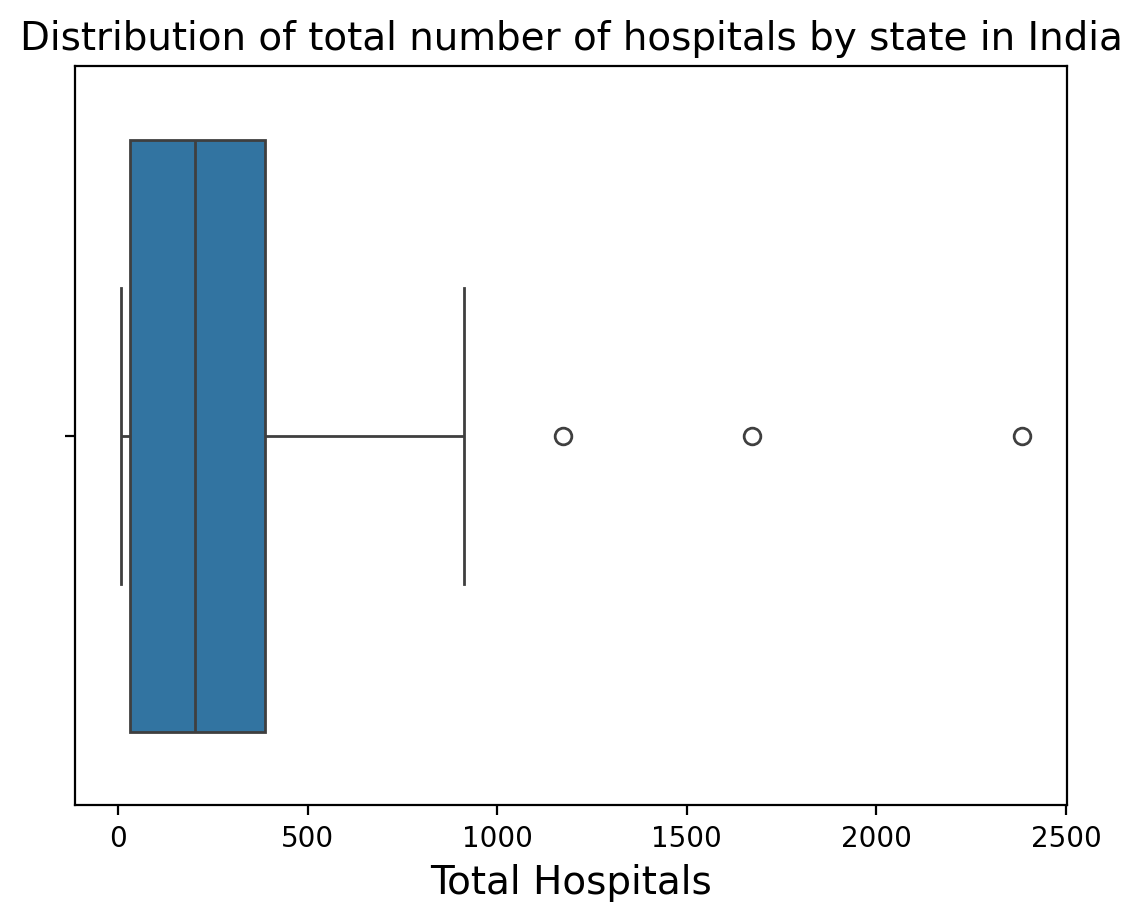

In [27]:
# Total Hospitals Boxplot
ax = sns.boxplot(x='TotHosp', data=masterdata)
ax.set_ylabel(None);
ax.set_xlabel('Total Hospitals', fontsize=14);
ax.set_title('Distribution of total number of hospitals by state in India', fontsize=14);
print(density.describe())

           PopDens
count    29.000000
mean    821.215727
std     557.725168
min     129.036463
25%     492.022210
50%     594.854243
75%    1077.264881
max    2310.891300


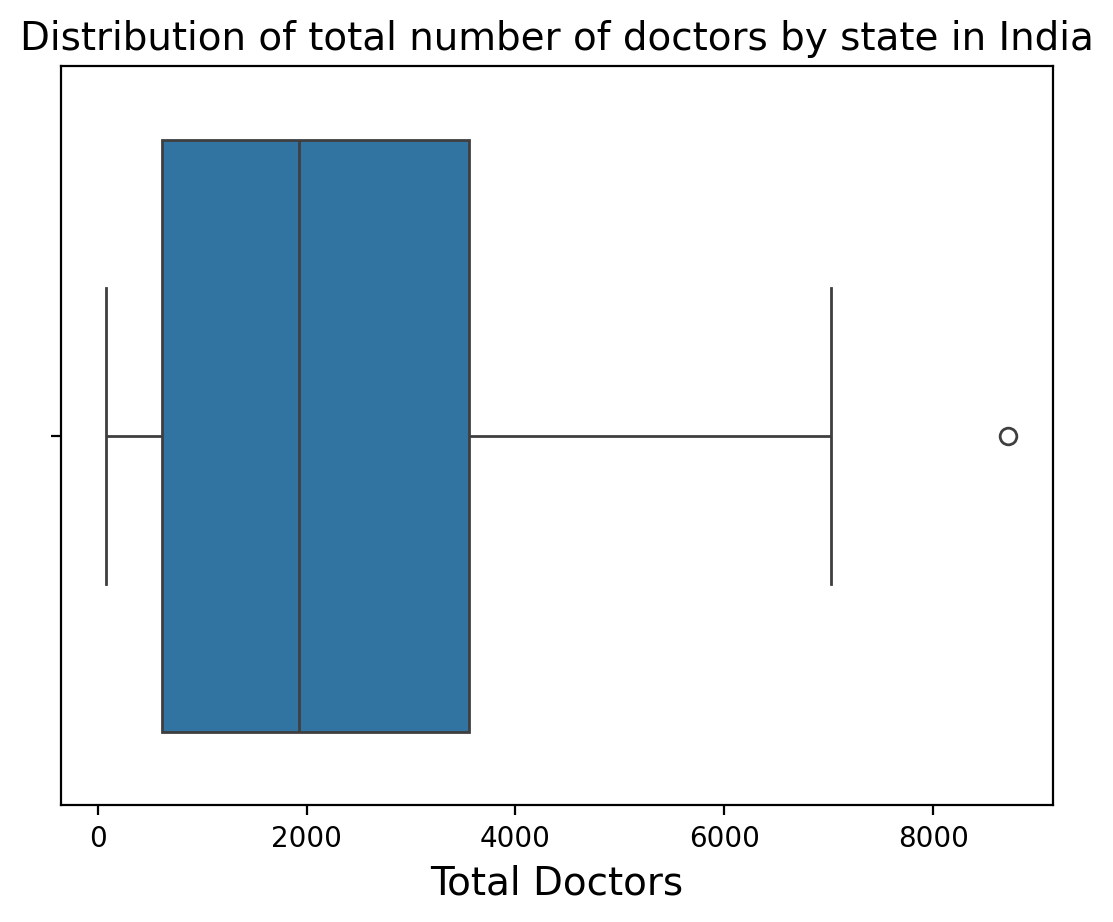

In [28]:
# Total Number of Doctors Boxplot
ax = sns.boxplot(x='TotDocs', data=masterdata)
ax.set_ylabel(None);
ax.set_xlabel('Total Doctors', fontsize=14);
ax.set_title('Distribution of total number of doctors by state in India', fontsize=14);
print(density.describe())

In [29]:
hosp = masterdata.sort_values(by=['TotHosp'], ascending=False)
hosp.head(10)

,StateName,SlumPop,TotPop,WorkPop,UrbanShare,PopDens,NewCases,NewDeaths,TotCases,TotDeaths,TotHosp,TotDocs
StateID,,,,,,,,,,,,
27,Maharashtra,1.184842e+07,112374333.0,49427878.0,0.200637,567.957049,8068,342,81074,4195,2385,8715.142857
9,Uttar Pradesh,6.239965e+06,199812341.0,65814715.0,0.154793,893.587399,1873,30,20958,287,1672,7019.219780
19,West Bengal,6.418594e+06,91276115.0,34756355.0,0.152630,1573.464570,611,20,6133,232,1172,4527.037095
20,Jharkhand,3.729990e+05,32988134.0,13098274.0,0.098896,497.532964,82,3,699,37,912,3854.000000
3,Punjab,1.460518e+06,27743338.0,9897362.0,0.279321,570.670202,322,18,4951,318,620,2198.000000
8,Rajasthan,2.068000e+06,68548437.0,29886255.0,0.160790,305.556707,2185,41,26698,353,591,4939.000000
5,Uttarakhand,4.877410e+05,10086292.0,3872275.0,0.140750,358.938353,51,0,988,0,490,1656.000000
33,Tamil Nadu,5.798459e+06,72147030.0,32884681.0,0.355546,836.535296,1885,24,29235,312,399,5338.144928
21,Odisha,1.560303e+06,41974218.0,17541589.0,0.109311,526.137487,103,1,1495,20,353,3527.000000


In [30]:
doc = masterdata.sort_values(by=['TotDocs'], ascending=False)
doc.head(10)

,StateName,SlumPop,TotPop,WorkPop,UrbanShare,PopDens,NewCases,NewDeaths,TotCases,TotDeaths,TotHosp,TotDocs
StateID,,,,,,,,,,,,
27,Maharashtra,1.184842e+07,112374333.0,49427878.0,0.200637,567.957049,8068,342,81074,4195,2385,8715.142857
9,Uttar Pradesh,6.239965e+06,199812341.0,65814715.0,0.154793,893.587399,1873,30,20958,287,1672,7019.219780
33,Tamil Nadu,5.798459e+06,72147030.0,32884681.0,0.355546,836.535296,1885,24,29235,312,399,5338.144928
8,Rajasthan,2.068000e+06,68548437.0,29886255.0,0.160790,305.556707,2185,41,26698,353,591,4939.000000
19,West Bengal,6.418594e+06,91276115.0,34756355.0,0.152630,1573.464570,611,20,6133,232,1172,4527.037095
24,Gujarat,1.680095e+06,60439692.0,24767747.0,0.215171,492.022210,3300,151,28596,1252,275,4299.000000
20,Jharkhand,3.729990e+05,32988134.0,13098274.0,0.098896,497.532964,82,3,699,37,912,3854.000000
28,Andhra Pradesh,1.018693e+07,84580777.0,39422906.0,0.133628,496.788720,2098,56,30328,765,236,3564.804945
29,Karnataka,3.291434e+06,61095297.0,27872597.0,0.234440,436.183207,503,19,8168,293,272,3532.000000


In [31]:
# Merge with shapefile
india_shapefile = india_shapefile.set_index('StateName')
masterdata['State'] = masterdata['StateName']
masterdata = masterdata.set_index('StateName')
masterdata = india_shapefile.join(masterdata, on='StateName')
masterdata.iloc[6, masterdata.columns.get_loc('State')] = "Dadra and Nagar Haveli"
masterdata.iloc[7, masterdata.columns.get_loc('State')] = "Daman and Diu"
masterdata.iloc[15, masterdata.columns.get_loc('State')] = "Lakshadweep"
masterdata.iloc[21, masterdata.columns.get_loc('State')] = "Nagaland"
masterdata.iloc[26, masterdata.columns.get_loc('State')] = "Sikkim"
masterdata

,geometry,StateID,SlumPop,TotPop,WorkPop,UrbanShare,PopDens,NewCases,NewDeaths,TotCases,TotDeaths,TotHosp,TotDocs,State
StateName,,,,,,,,,,,,,,
Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",35,1.417200e+04,380581.0,152535.0,0.113842,430.414550,33.0,0.0,423.0,0.0,7.0,117.000000,Andaman and Nicobar Islands
Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",12,1.556200e+04,1383727.0,587657.0,0.073746,83257.997758,1.0,0.0,25.0,0.0,38.0,347.000000,Arunachal Pradesh
Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578...",18,1.972660e+05,31205576.0,11969690.0,0.100743,828.554764,36.0,1.0,794.0,17.0,240.0,1458.000000,Assam
Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",10,1.237682e+06,104099452.0,34724987.0,0.067551,1237.437277,277.0,2.0,2450.0,38.0,112.0,2352.642857,Bihar
Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552...",4,9.513500e+04,1055450.0,404136.0,0.972532,9258.333000,36.0,0.0,669.0,0.0,6.0,1052.000000,Chandigarh
Chhattisgarh,"POLYGON ((83.94694 23.62196, 83.95594 23.62406...",22,1.898931e+06,25545198.0,12180225.0,0.133256,1077.264881,37.0,0.0,716.0,0.0,277.0,1509.000000,Chhattisgarh
Dadra and Nagar Haveli,"POLYGON ((73.20640 20.12165, 73.20865 20.10695...",26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dadra and Nagar Haveli
Daman and Diu,"POLYGON ((72.80144 20.37378, 72.84418 20.47463...",25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Daman and Diu
Goa,"POLYGON ((74.11982 15.65278, 74.24806 15.65698...",30,2.624700e+04,1458545.0,577248.0,0.521562,552.891793,7.0,0.0,204.0,0.0,16.0,589.000000,Goa


### Choropleths

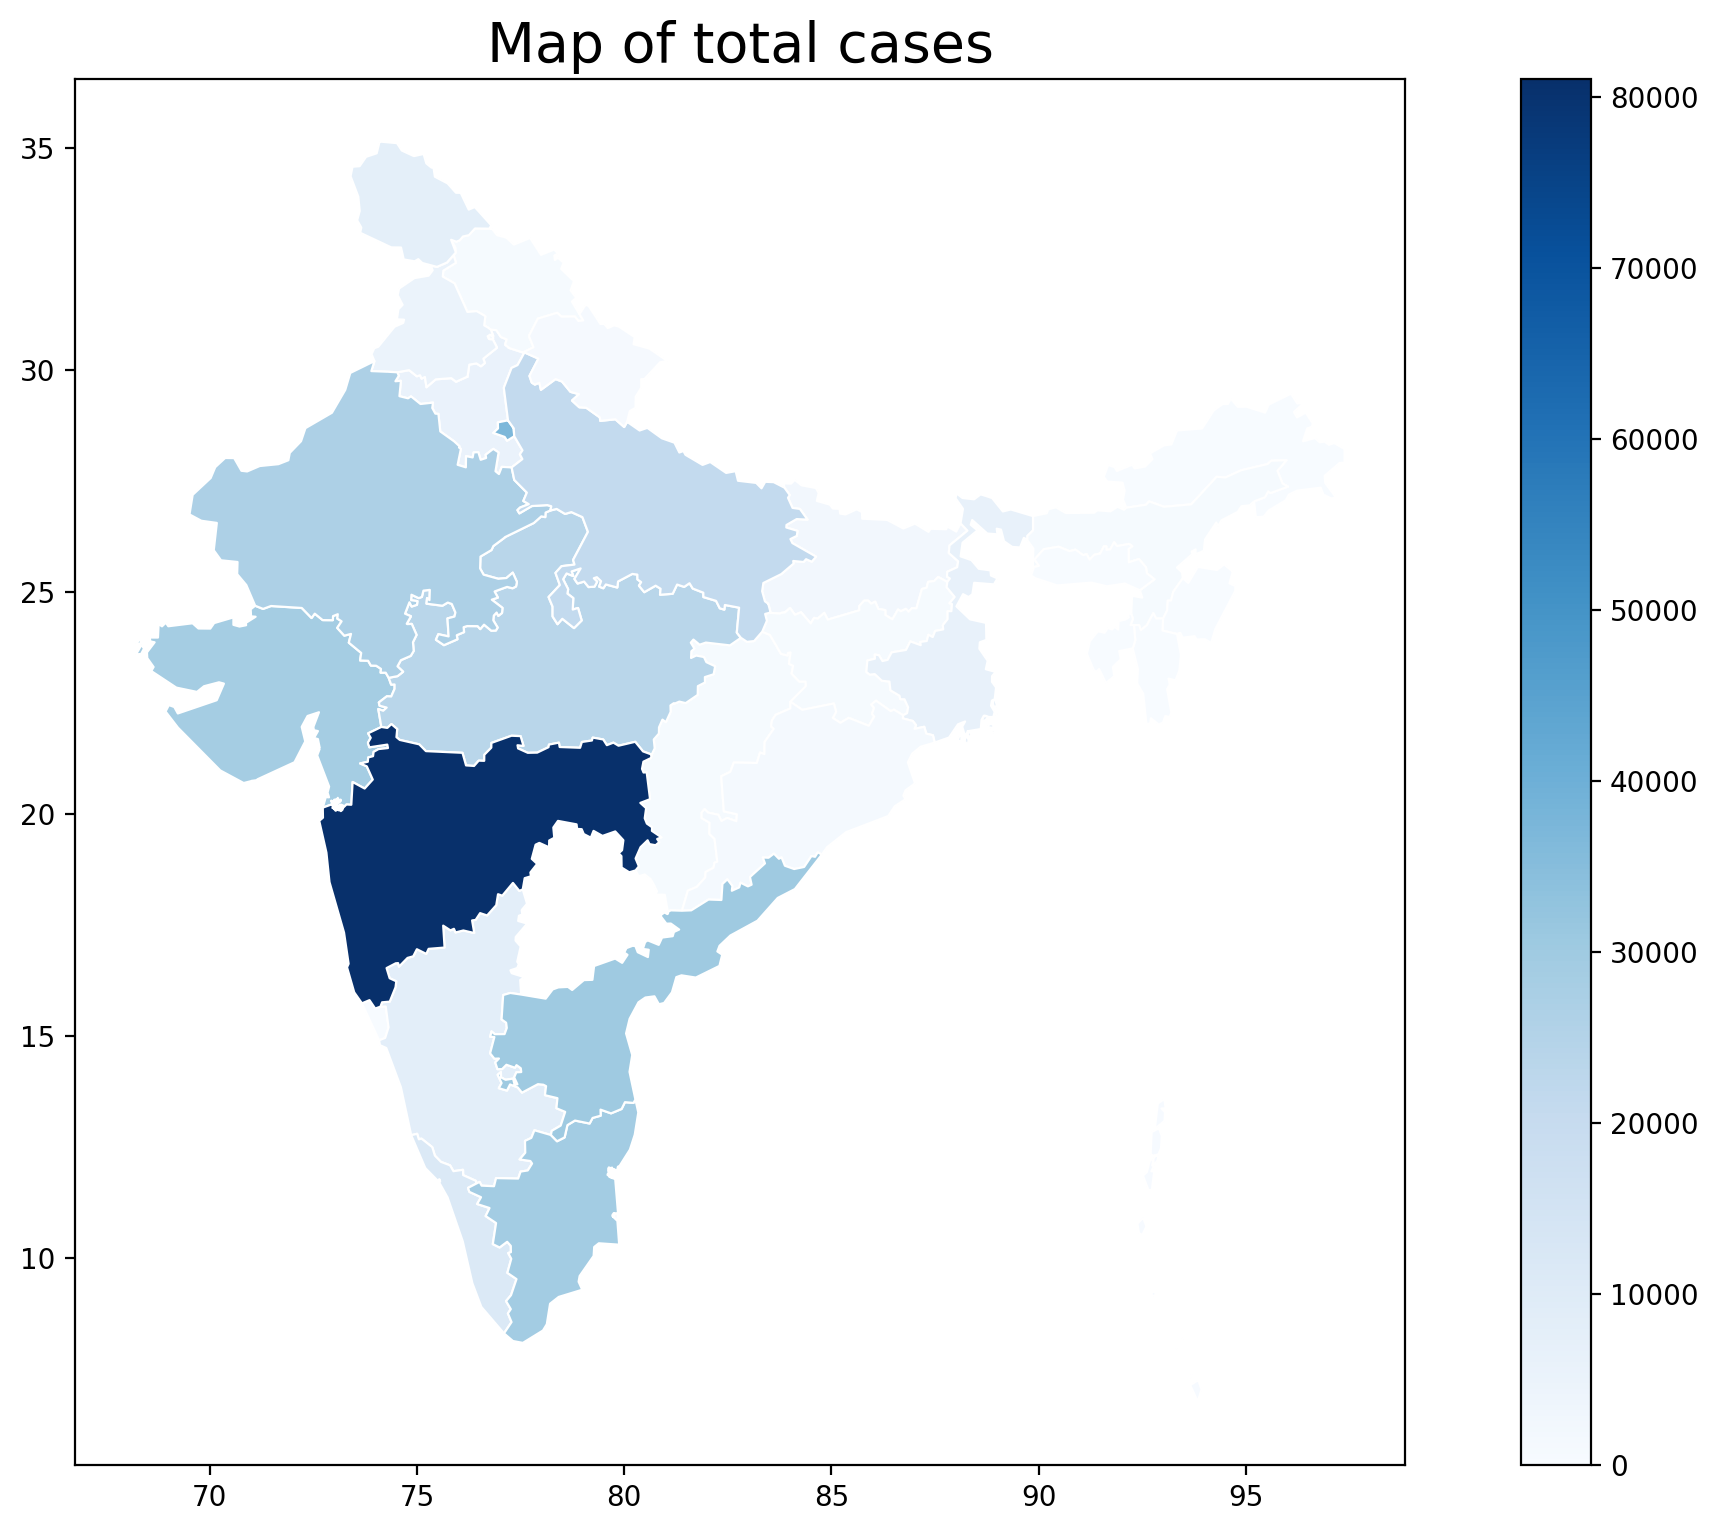

In [37]:
vmin, vmax = 0, masterdata.TotCases.max()
fig, ax = plt.subplots(figsize=(15, 9))
masterdata.plot(column='TotCases', cmap=plt.cm.Blues, linewidth=0.8, ax=ax, edgecolor='w')

# create a ScalarMappable for colormap normalization
norm = Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(cmap=plt.cm.Blues, norm=norm)

# empty array for the data range
sm._A = []

# add the colorbar to the figure, specifying the axes
cbar = fig.colorbar(sm, ax=ax)

ax.set_title('Map of total cases', fontdict={'fontsize': '20', 'fontweight': '3'})
plt.show()

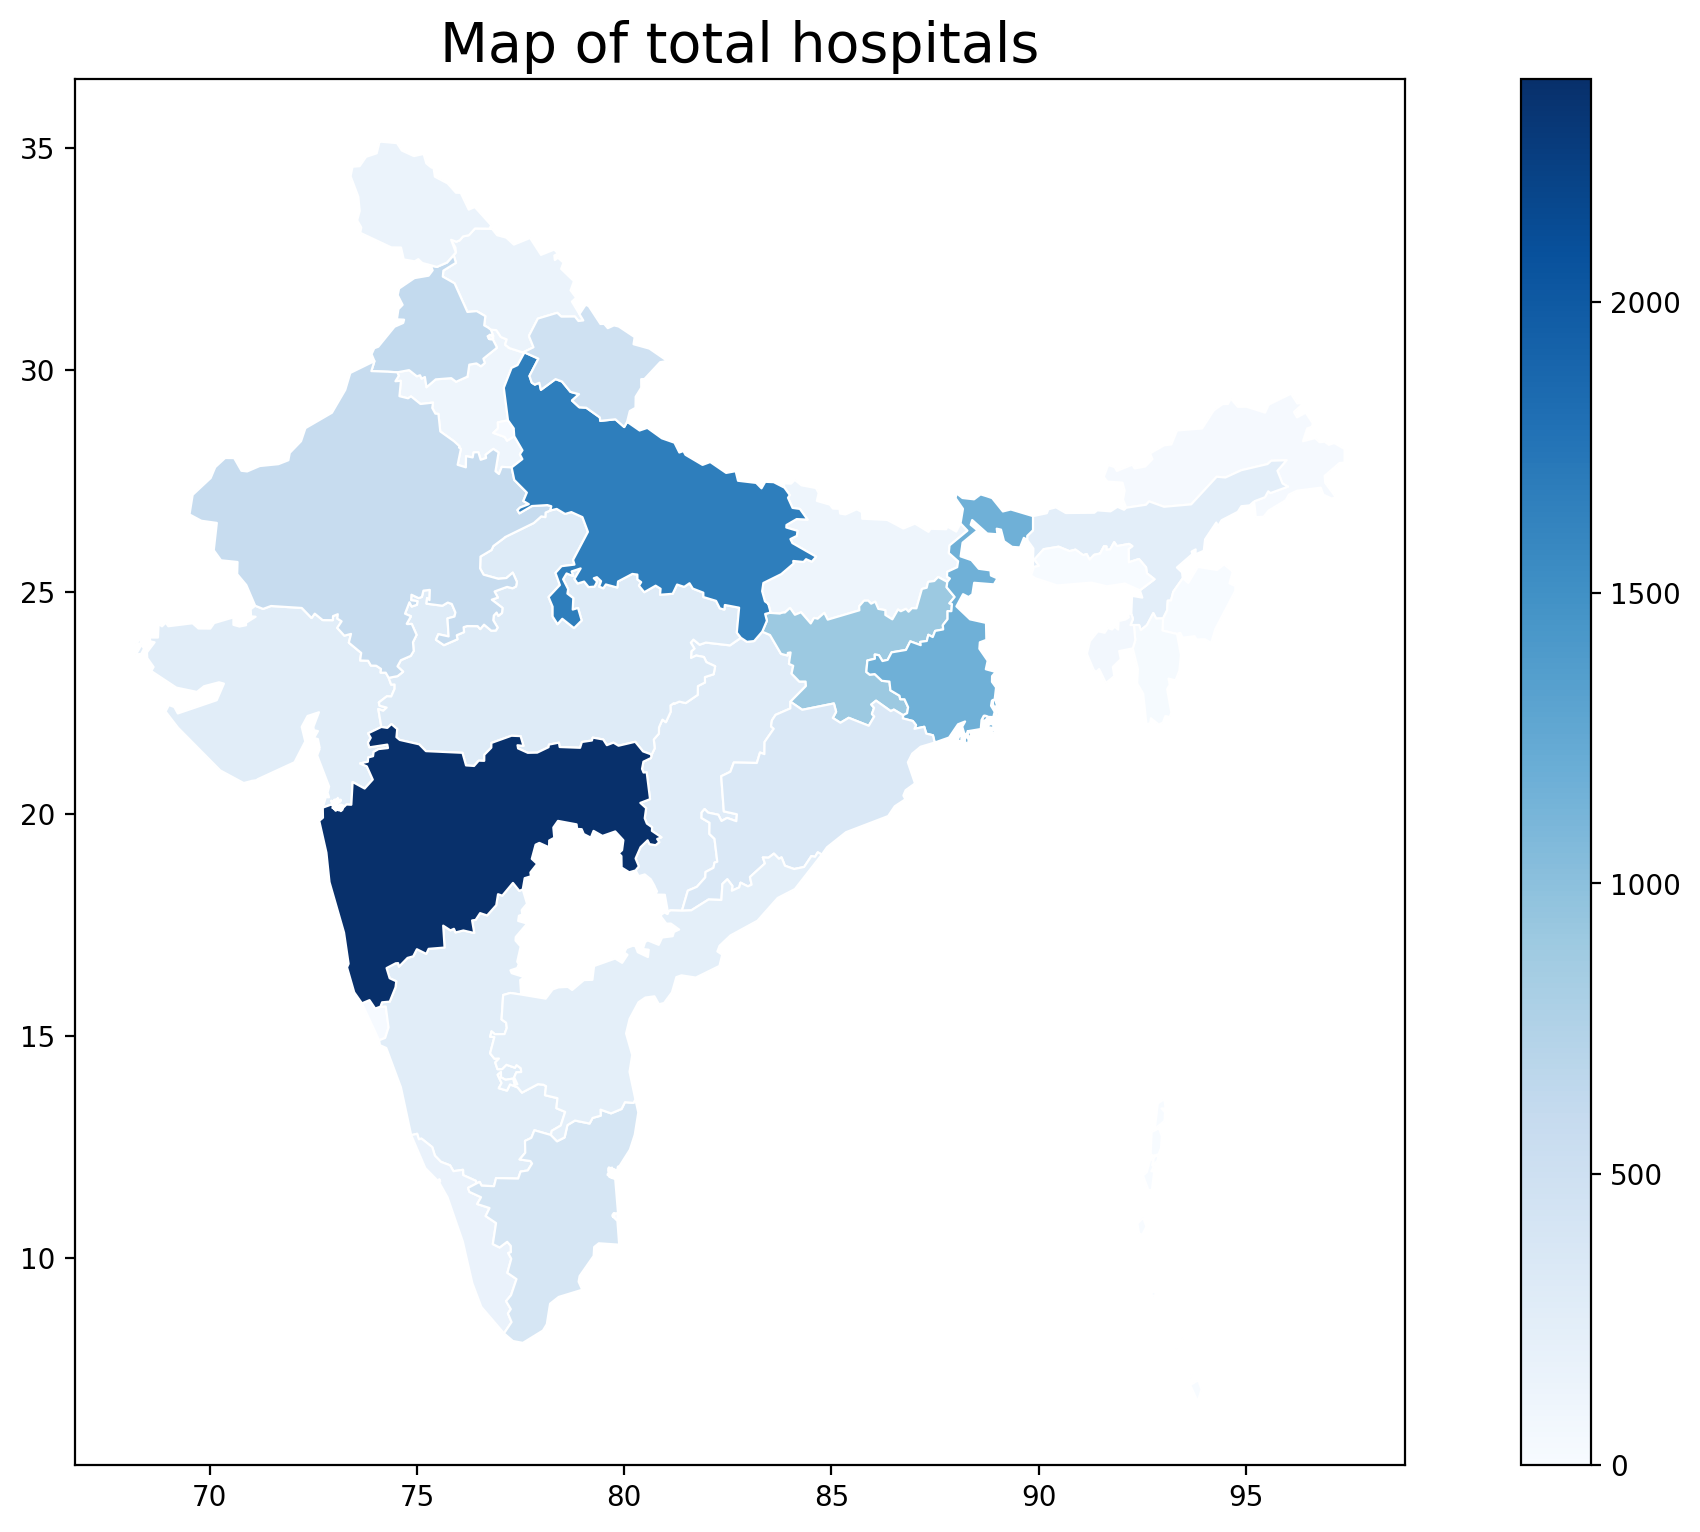

In [39]:
vmin, vmax = 0, masterdata.TotHosp.max()
fig, ax = plt.subplots(figsize=(15, 9))
masterdata.plot(column='TotHosp', cmap=plt.cm.Blues, linewidth=0.8, ax=ax, edgecolor='w')

# create a ScalarMappable for colormap normalization
norm = Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(cmap=plt.cm.Blues, norm=norm)

sm._A = []
cbar = fig.colorbar(sm, ax=ax)

ax.set_title('Map of total hospitals', fontdict={'fontsize': '20', 'fontweight': '3'})
plt.show()

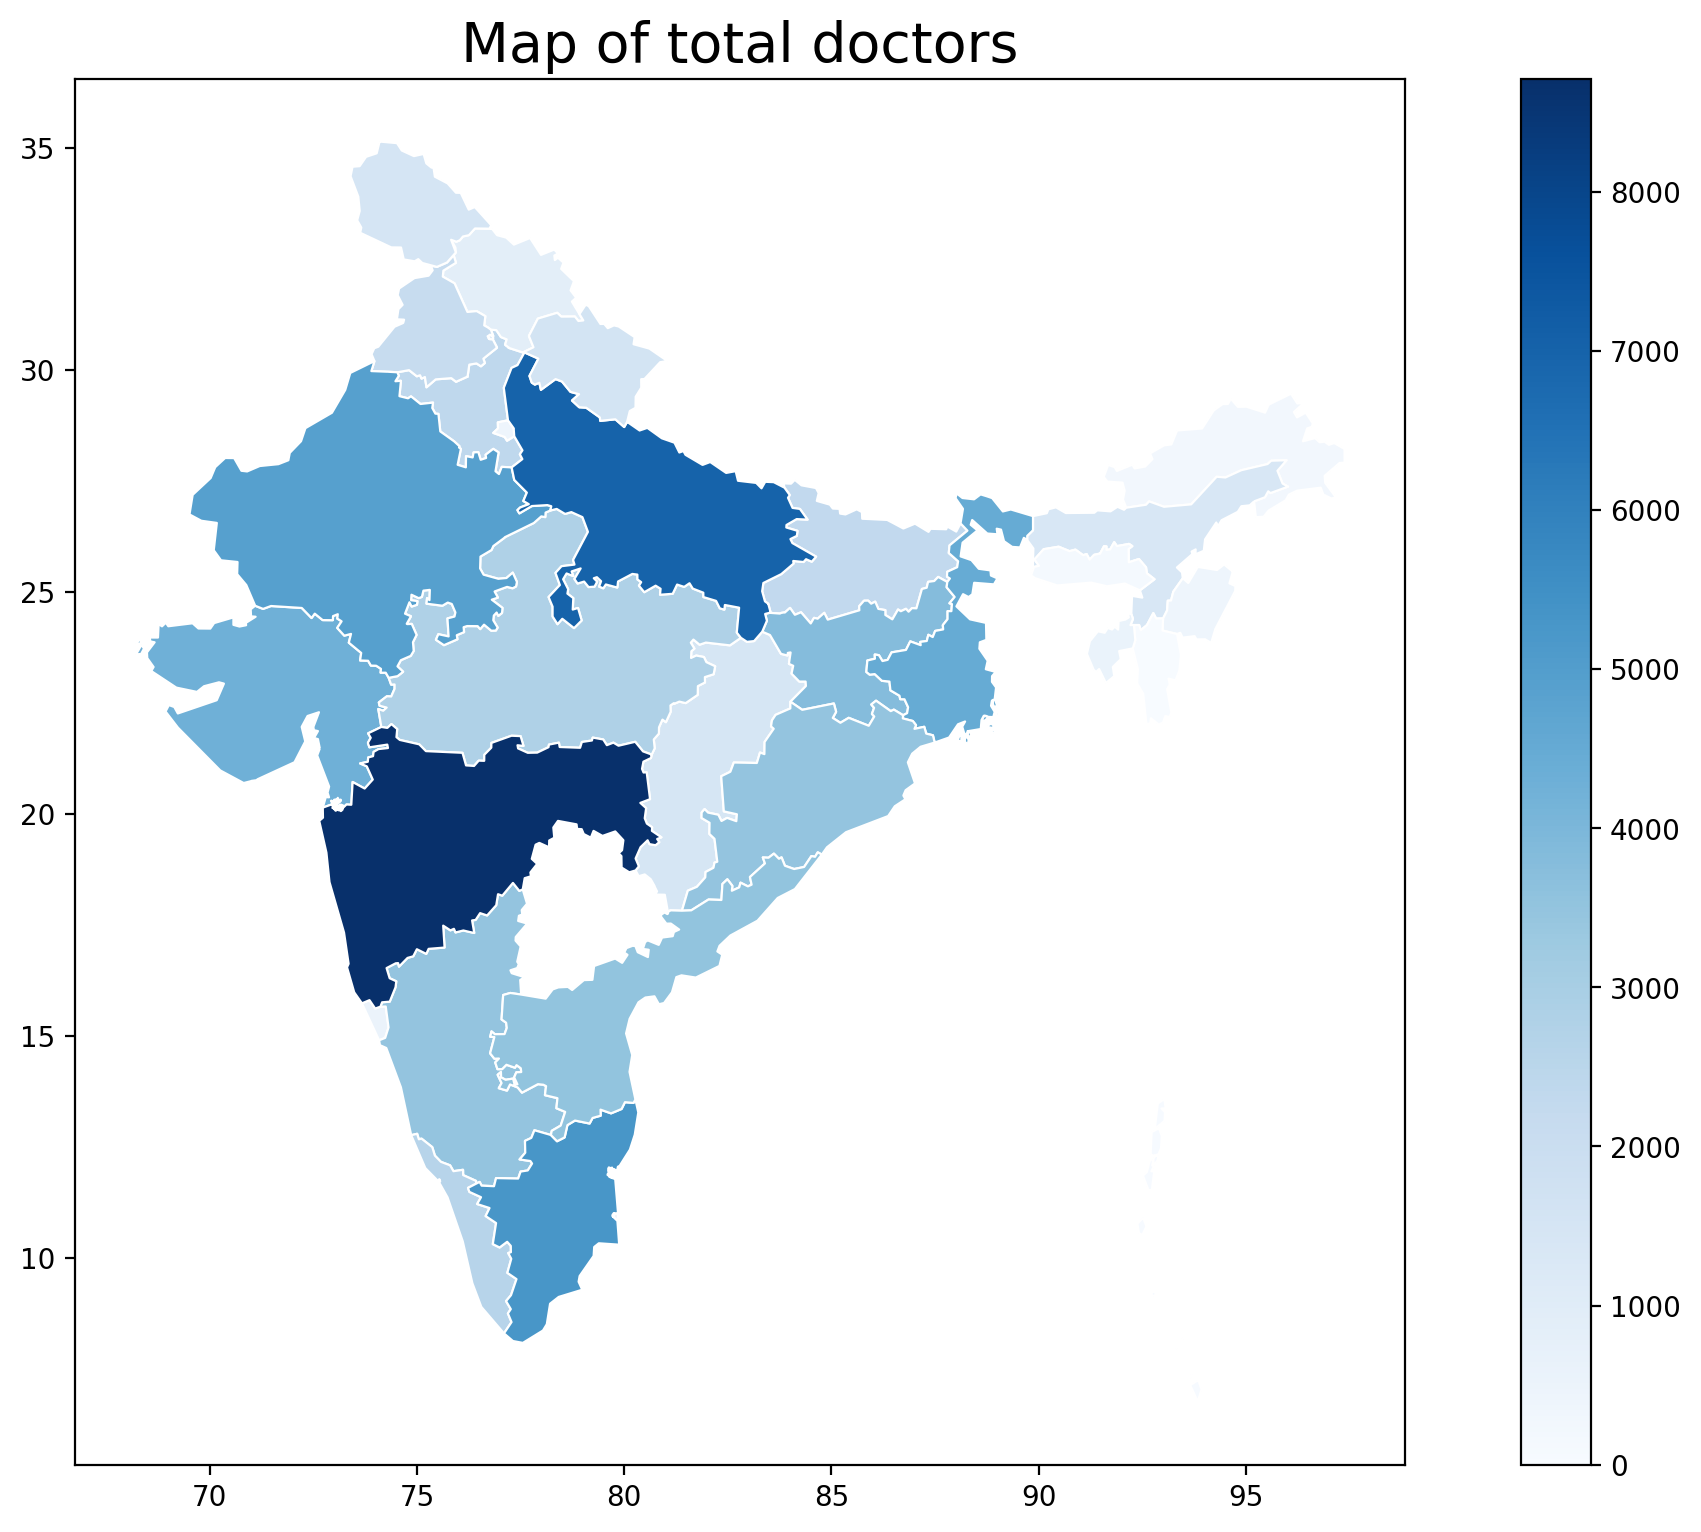

In [40]:
vmin, vmax = 0, masterdata.TotDocs.max()
fig, ax = plt.subplots(figsize=(15, 9))
masterdata.plot(column='TotDocs', cmap=plt.cm.Blues, linewidth=0.8, ax=ax, edgecolor='w')

# create a ScalarMappable for colormap normalization
norm = Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(cmap=plt.cm.Blues, norm=norm)

sm._A = []
cbar = fig.colorbar(sm, ax=ax)

ax.set_title('Map of total doctors', fontdict={'fontsize': '20', 'fontweight': '3'})
plt.show()

### Linear Regression

In [41]:
def simple_linear_regression_fit(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    
    x = x.reshape(x.shape[0], 1)
    y = y.reshape(y.shape[0], 1)
    y_bar = np.mean(y)
    x_bar = np.mean(x)
    numerator = np.sum( (x - x_bar)*(y - y_bar) )
    denominator = np.sum((x - x_bar)**2)
    beta_1 = numerator/denominator
    beta_0 = y_bar - beta_1*x_bar

    return beta_0, beta_1

R-squared value is: 0.83


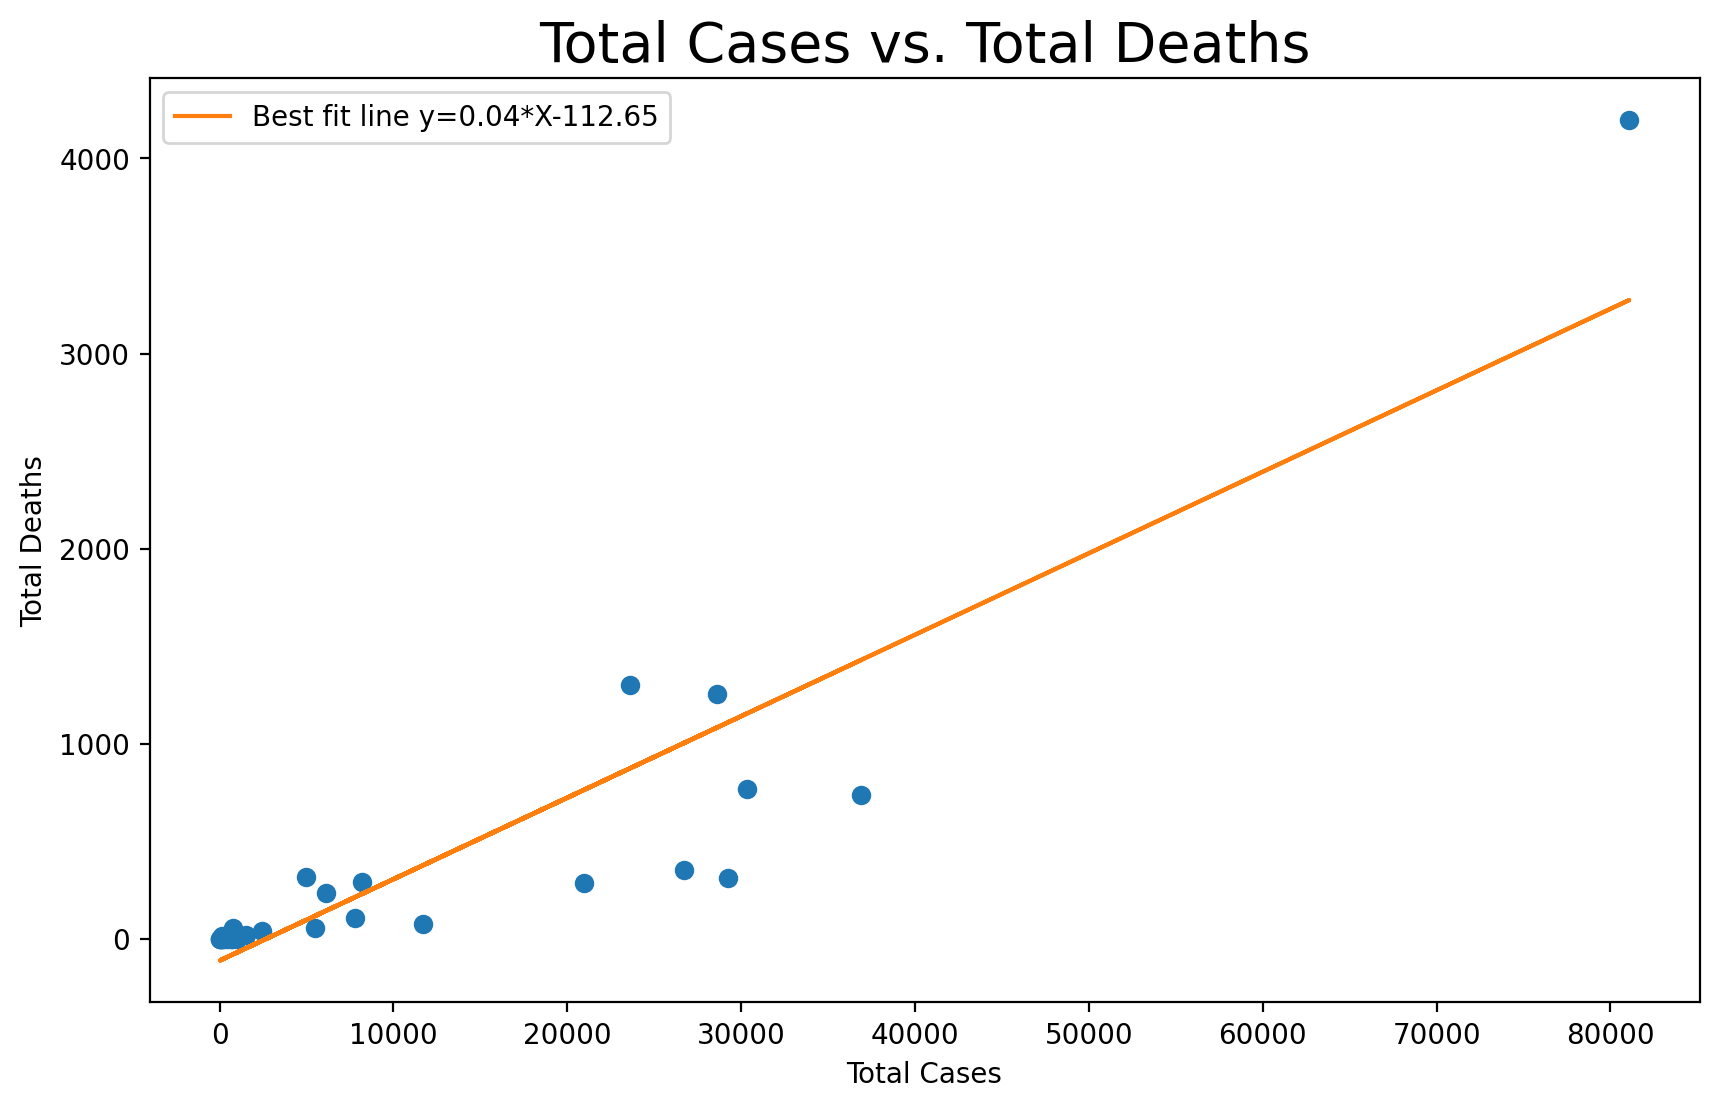

In [42]:
# Cases vs. Deaths
CasesDeaths = masterdata[['TotCases', 'TotDeaths']]
CasesDeaths = CasesDeaths[CasesDeaths['TotDeaths'].notna()]
X = np.asarray(CasesDeaths['TotCases'], dtype=None, order=None)
Y = np.asarray(CasesDeaths['TotDeaths'], dtype=None, order=None)

betas = simple_linear_regression_fit(X,Y)
beta0 = round(betas[0],2)
beta1 = round(betas[1],2)
plt.figure(figsize=(10,6))
plt.plot(X, Y, 'o')
plt.plot(X, betas[1]*X + betas[0], ls='-', label=f'Best fit line y={beta1}*X{beta0}')

plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Total Cases vs. Total Deaths', fontdict={'fontsize': 20})
plt.legend()

model = np.polyfit(X, Y, 1)
from sklearn.metrics import r2_score
predict = np.poly1d(model)
print(f'R-squared value is: {round(r2_score(Y, predict(X)),2)}')

R-squared value is: 0.46


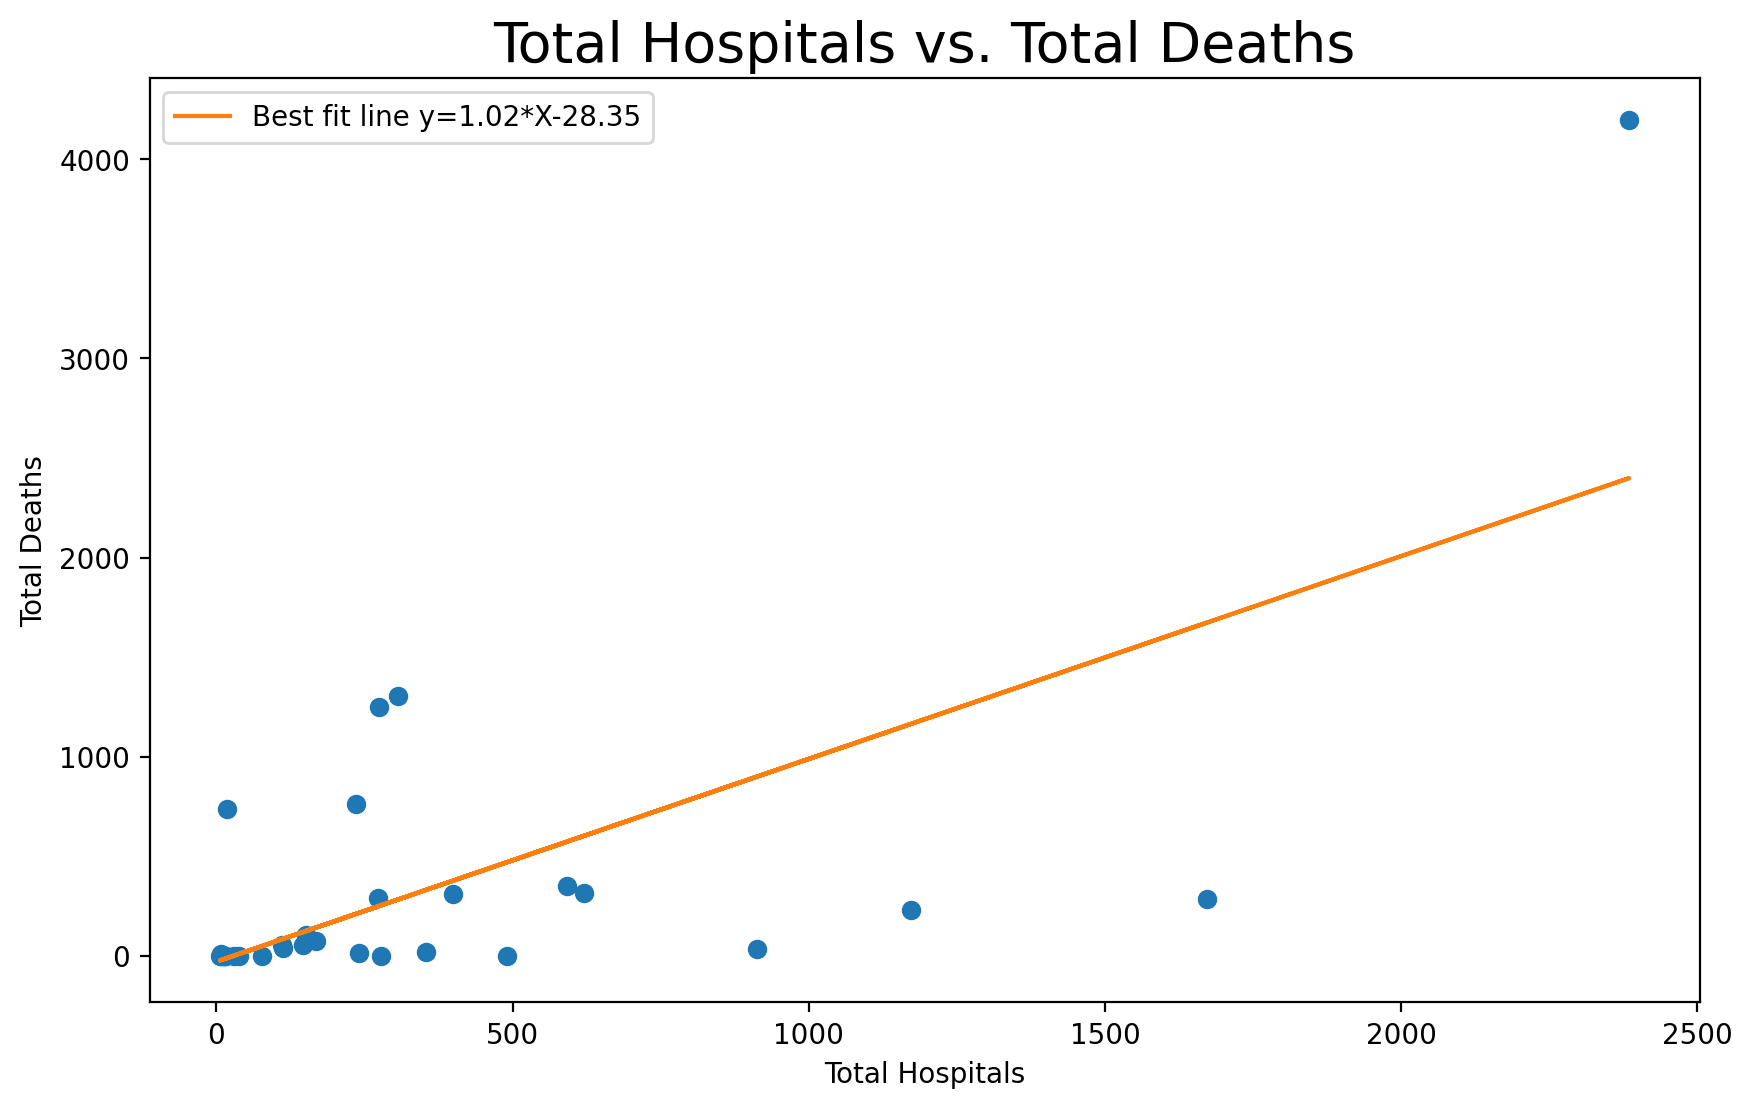

In [43]:
# Total hospitals as a predictor for deaths
data = masterdata[['TotHosp', 'TotDeaths']]
data = data[data['TotDeaths'].notna()]
X = np.asarray(data['TotHosp'], dtype=None, order=None)
Y = np.asarray(data['TotDeaths'], dtype=None, order=None)

betas = simple_linear_regression_fit(X,Y)
beta0 = round(betas[0],2)
beta1 = round(betas[1],2)
plt.figure(figsize=(10,6))
plt.plot(X, Y, 'o')
plt.plot(X, betas[1]*X + betas[0], ls='-', label=f'Best fit line y={beta1}*X{beta0}')

plt.xlabel('Total Hospitals')
plt.ylabel('Total Deaths')
plt.title('Total Hospitals vs. Total Deaths', fontdict={'fontsize': 20})
plt.legend()

model = np.polyfit(X, Y, 1)
from sklearn.metrics import r2_score
predict = np.poly1d(model)
print(f'R-squared value is: {round(r2_score(Y, predict(X)),2)}')

R-squared value is: 0.41


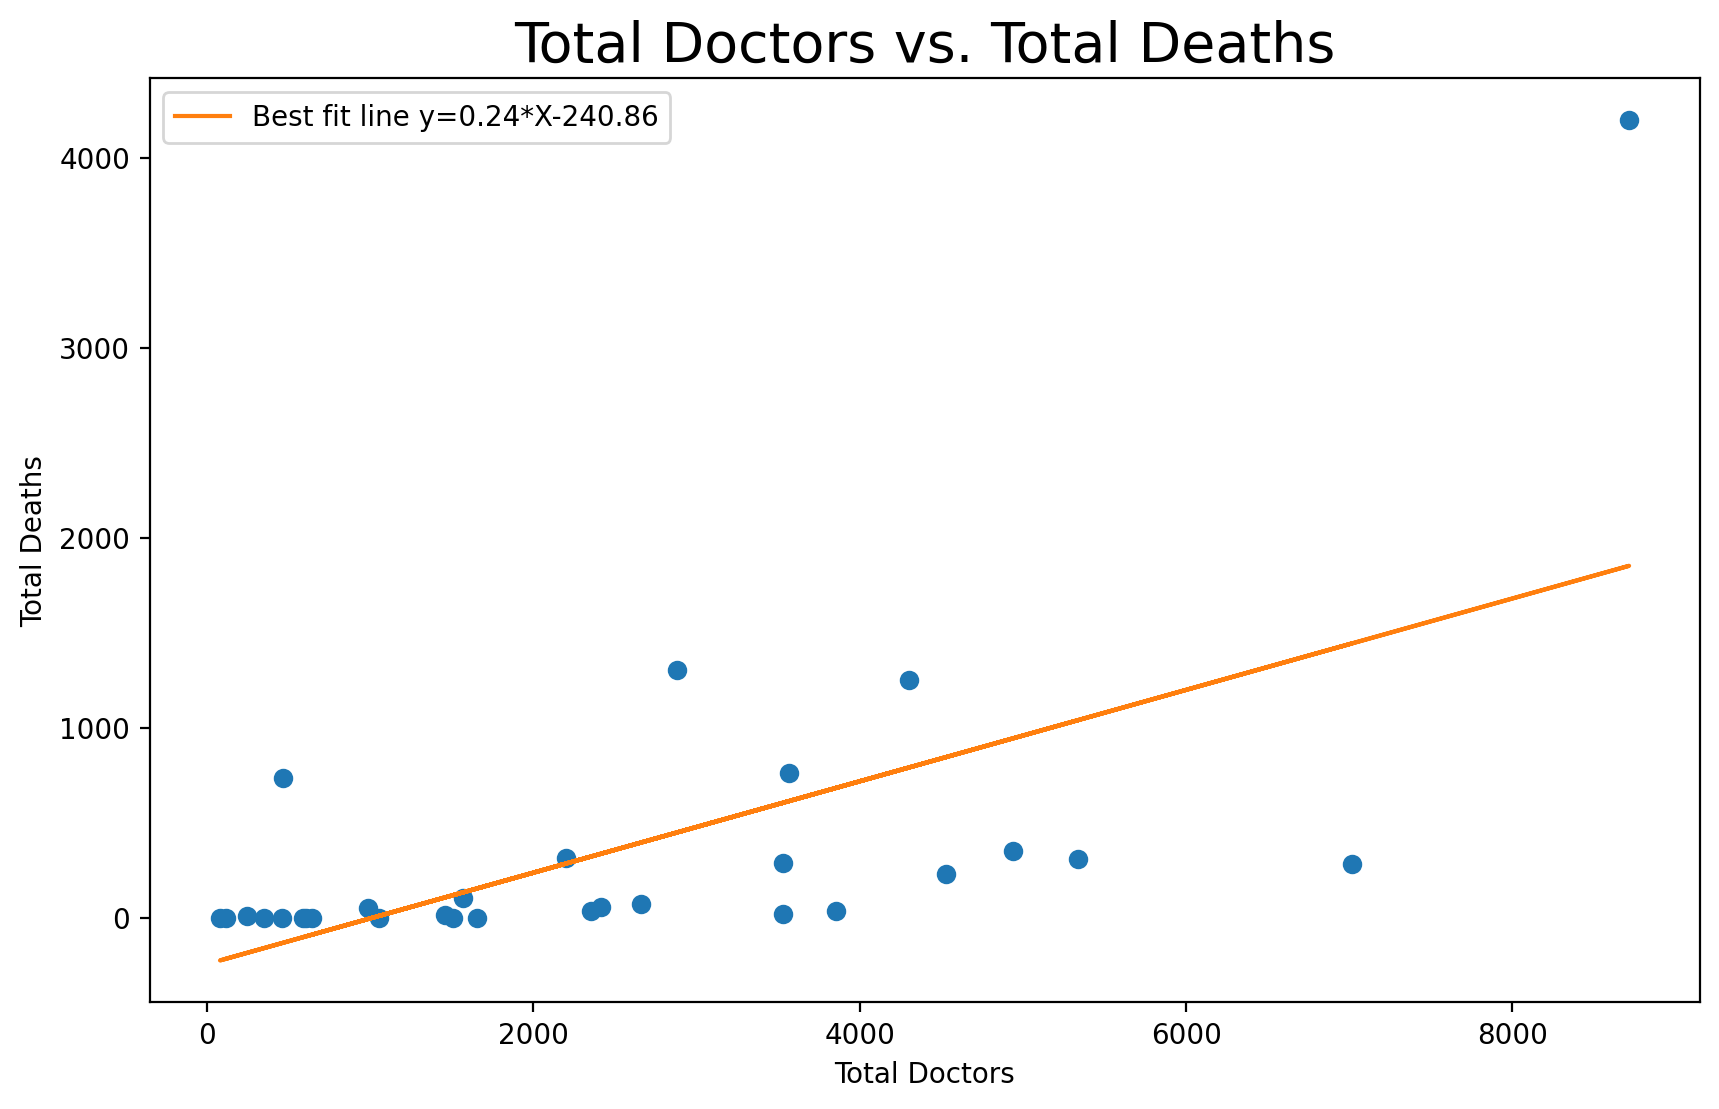

In [44]:
# Total doctors as a predictor for deaths
data = masterdata[['TotDocs', 'TotDeaths']]
data = data[data['TotDeaths'].notna()]
X = np.asarray(data['TotDocs'], dtype=None, order=None)
Y = np.asarray(data['TotDeaths'], dtype=None, order=None)

betas = simple_linear_regression_fit(X,Y)
beta0 = round(betas[0],2)
beta1 = round(betas[1],2)
plt.figure(figsize=(10,6))
plt.plot(X, Y, 'o')
plt.plot(X, betas[1]*X + betas[0], ls='-', label=f'Best fit line y={beta1}*X{beta0}')

plt.xlabel('Total Doctors')
plt.ylabel('Total Deaths')
plt.title('Total Doctors vs. Total Deaths', fontdict={'fontsize': 20})
plt.legend()

model = np.polyfit(X, Y, 1)
from sklearn.metrics import r2_score
predict = np.poly1d(model)
print(f'R-squared value is: {round(r2_score(Y, predict(X)),2)}')

R-squared value is: 0.73


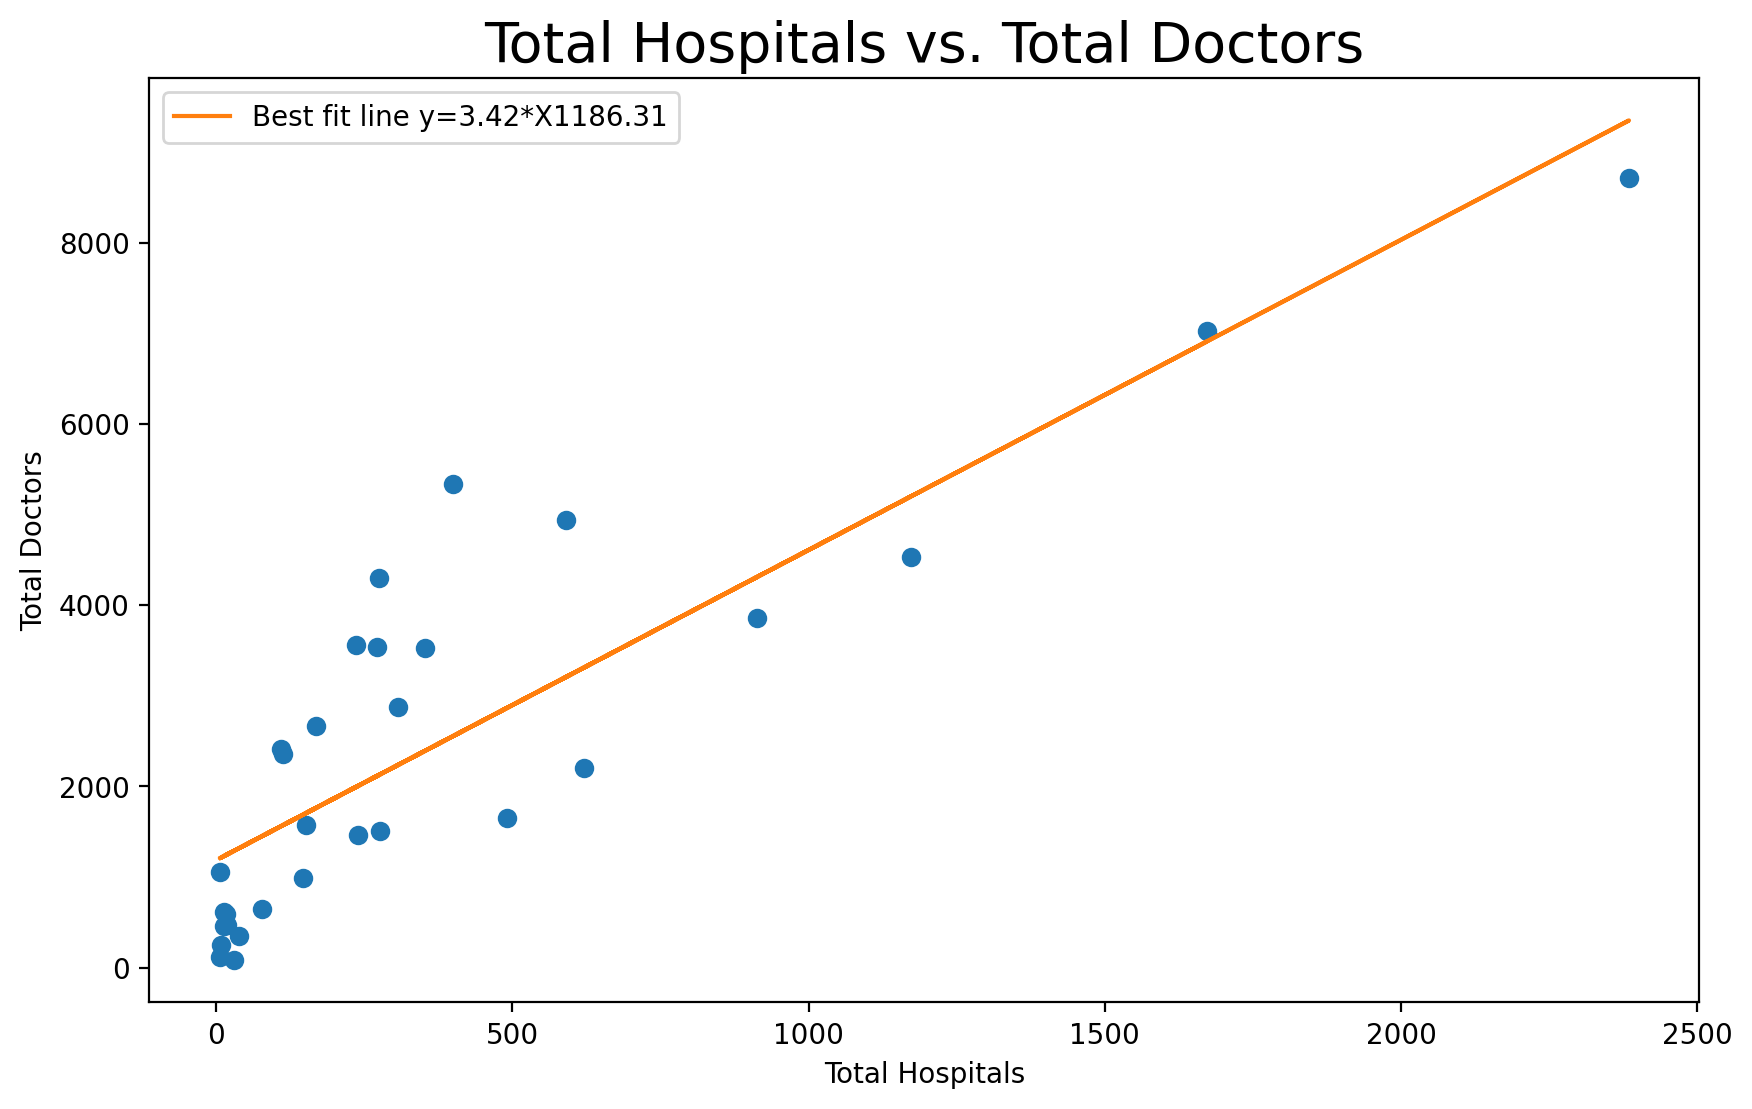

In [45]:
# Total hospital as a predictor for total doctors
data = masterdata[['TotDocs', 'TotHosp']]
data = data[data['TotDocs'].notna()]
X = np.asarray(data['TotHosp'], dtype=None, order=None)
Y = np.asarray(data['TotDocs'], dtype=None, order=None)

betas = simple_linear_regression_fit(X,Y)
beta0 = round(betas[0],2)
beta1 = round(betas[1],2)
plt.figure(figsize=(10,6))
plt.plot(X, Y, 'o')
plt.plot(X, betas[1]*X + betas[0], ls='-', label=f'Best fit line y={beta1}*X{beta0}')

plt.xlabel('Total Hospitals')
plt.ylabel('Total Doctors')
plt.title('Total Hospitals vs. Total Doctors', fontdict={'fontsize': 20})
plt.legend()

model = np.polyfit(X, Y, 1)
from sklearn.metrics import r2_score
predict = np.poly1d(model)
print(f'R-squared value is: {round(r2_score(Y, predict(X)),2)}')

Text(0.5, 1.0, 'Total Doctors')

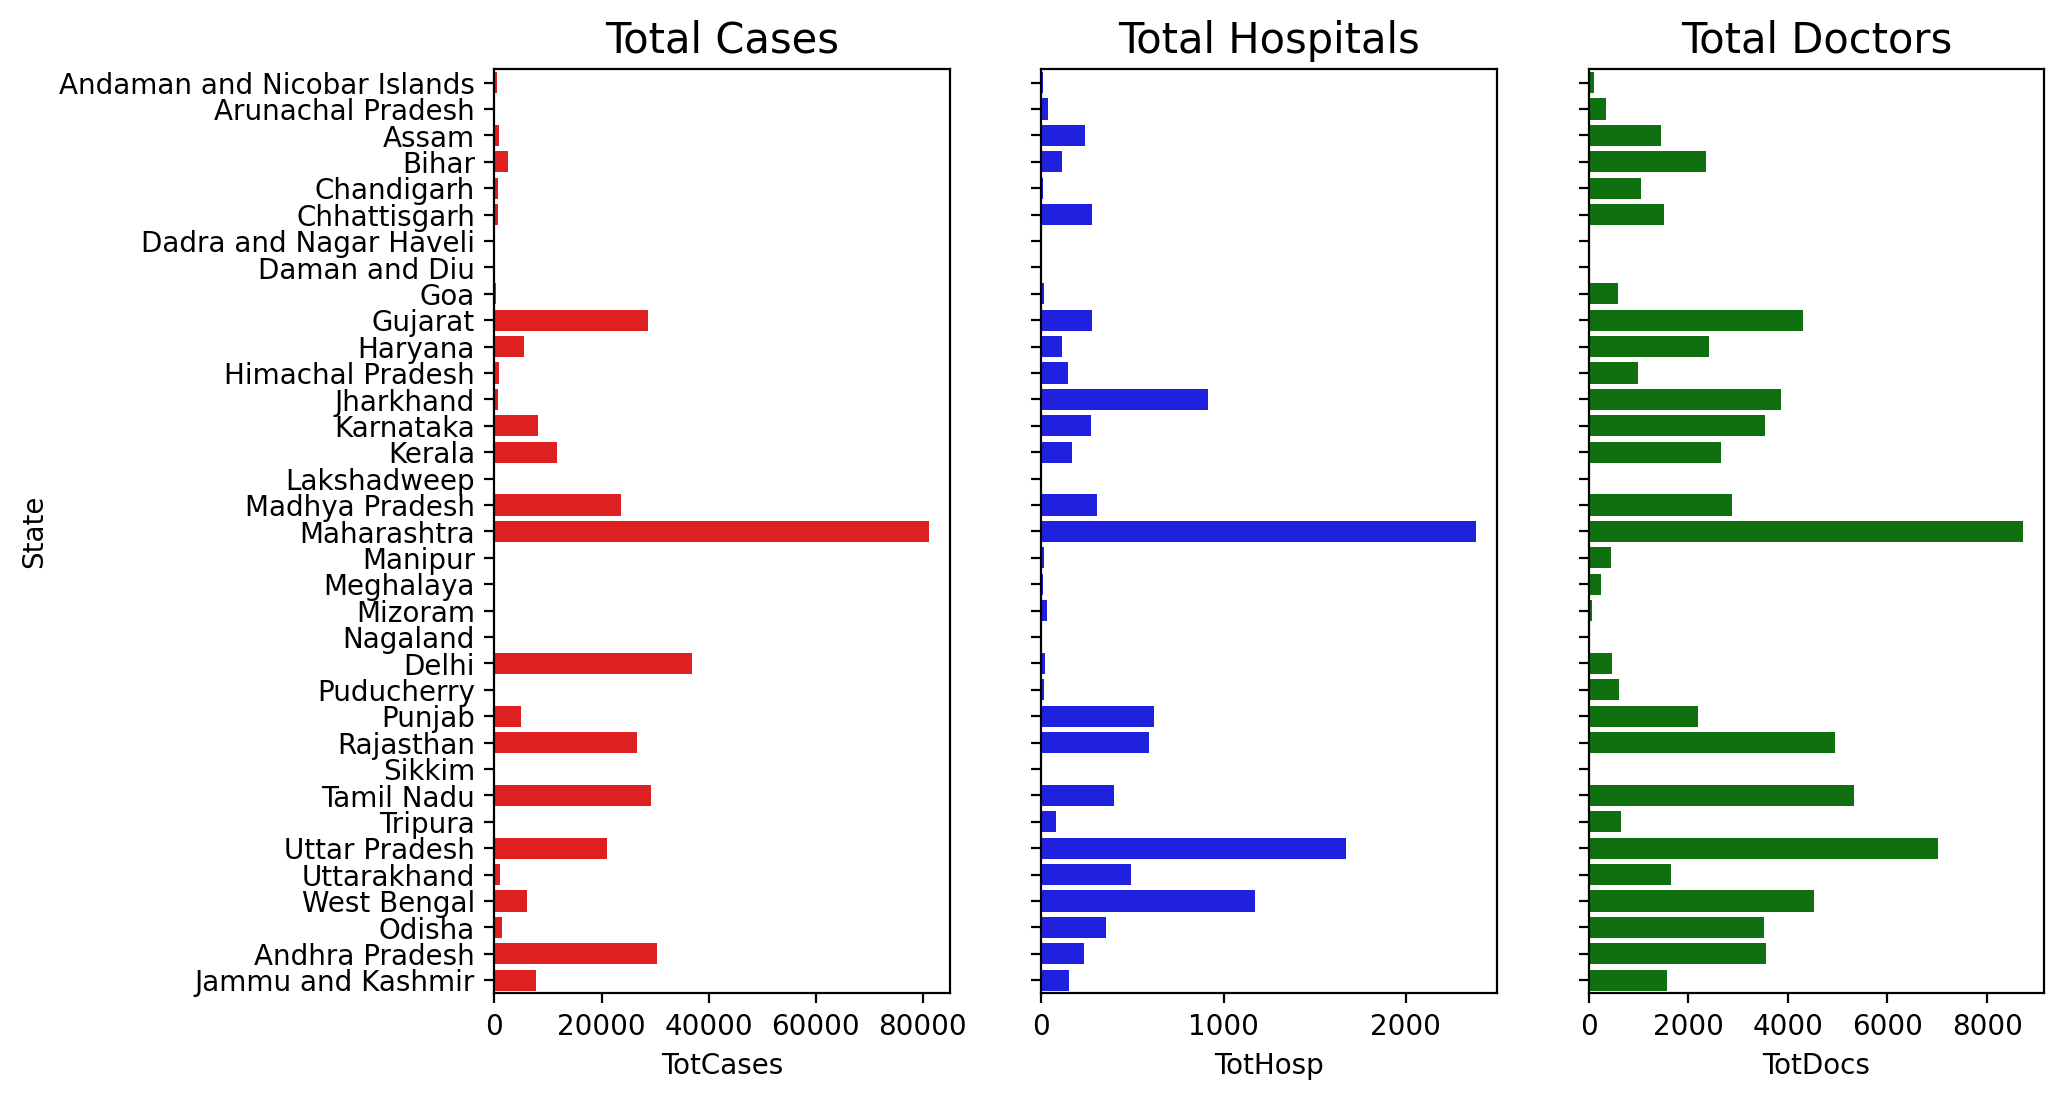

In [46]:
# Number of cases by state
f, ax = plt.subplots(ncols=3, figsize=(10,6))
g1 = sns.barplot(x='TotCases', y='State', data=masterdata,color='red',ax=ax[0])
plt.yticks(rotation=0)
g1.set_title('Total Cases', fontdict={'fontsize': '15', 'fontweight': '3'})

g2 = sns.barplot(x='TotHosp', y='State', data=masterdata,color='blue',ax=ax[1])
g2.set(ylabel='')
g2.set(yticklabels=[])
g2.set_title('Total Hospitals', fontdict={'fontsize': '15', 'fontweight': '3'})

g3 = sns.barplot(x='TotDocs', y='State', data=masterdata,color='green',ax=ax[2])
g3.set(ylabel='')
g3.set(yticklabels=[])
g3.set_title('Total Doctors', fontdict={'fontsize': '15', 'fontweight': '3'})
